In [119]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Activation,Dense,Input,Lambda
from keras.losses import mean_squared_error,mse
from keras.models import Sequential,Model,save_model,load_model
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import  ImageDataGenerator
from keras.optimizers import Adam
%matplotlib inline
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['image.cmap']='viridis'

## First Step, Prepare Mnist Dataset
* different from supervise learning,I only using X
* using dense Layer as encoder and decoder,so X is 784 dims

In [6]:
mnist_data_path='../AI_database/mnist/MNIST_DATA'
def imshow(X,Y=None,classes=None):
    '''
        show Batch of image in grids sqrt(h) x sqrt(w)
        X is a numpy array,size (m,h,w,c)
        Y is a numpy array,size (m,#classes)
    '''
    m=X.shape[0]
    gridSize=int(m**0.5)
    for i in range(0,gridSize):
        for j in range(0,gridSize):
            _idx=i*gridSize+j
            im=X[_idx]
            plt.subplot(gridSize,gridSize,_idx+1)
            plt.axis('off')
            plt.imshow(im)
            if Y is not None:
                label=classes[np.argmax(Y[_idx])]
                plt.title(label)

def load_dataset(flaten=False,one_hot=True):
    def _make_one_hot(d,C=10):
        return (np.arange(C)==d[:,None]).astype(np.int32)

    mnist=input_data.read_data_sets(mnist_data_path)
    X_train,Y_train=mnist.train.images,mnist.train.labels
    X_test,Y_test=mnist.test.images,mnist.test.labels

    if flaten==False:
        X_train=X_train.reshape((-1,28,28,1))
        X_test = X_test.reshape((-1, 28, 28,1))
    if one_hot:
        Y_train = _make_one_hot(Y_train)
        Y_test=_make_one_hot(Y_test)


    print('\n-------------------------------------------------------------------------')
    print('load %d train Example,%d Test Example'%(X_train.shape[0],X_test.shape[0]))
    print('Train Images  Shape:'+str(X_train.shape))
    print('Train Labels  Shape:' + str(Y_train.shape))
    print('Test  Images  Shape:'+str(X_test.shape))
    print('Test  Labels  Shape:' + str(Y_test.shape))
    print('-------------------------------------------------------------------------')
    return (X_train,Y_train,X_test,Y_test)

In [7]:
X_train,Y_train,X_test,Y_test=load_dataset(flaten=True,one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../AI_database/mnist/MNIST_DATA/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../AI_database/mnist/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

-------------------------------------------------------------------------
load 55000 train Example,10000 Test Example
Train Images  Shape:(55000, 784)
Train Labels  Shape:(55000,)
Test  Images  Shape:(10000, 784)
Test  Labels  Shape:(10000,)
-----------------------------------

## define show Help function

In [9]:
def reshaper(X):
    m=X.shape[0]
    return X.reshape((m,28,28))

## Define a encoder
* ###  the struct is X---->H1---->(Uz,logVarz,z) 

In [101]:
def vae_encoder(n_x=784,n_h=512,n_z=2):
    '''
        n_x:dim of Image
        n_x:dim of hidden units
        n_z:dim of latent variable
        return:,a model with outputs=[u_z,logvar_z,z] all have same dims n_z
    '''
    def sample(args):
        '''
            args:u,logvar,2 tensor object
            sample from N(0,I),then transform it to N(u,exp(logvar))
            return:a tensor 
        '''
        u,logvar=args
        batch,ndim=tf.shape(u)[0],tf.shape(u)[1]
        
        z=K.random_normal(shape=[batch,ndim])
        return u+K.exp(0.5*logvar)*z
    
    X_Input=Input(shape=(n_x,),name='encode_input')
    X=Dense(n_h,activation='relu',name='encode_hidden',kernel_initializer='he_normal')(X_Input)
    
    u_z=Dense(n_z,name='encode_mean',kernel_initializer='he_normal')(X)
    logvar_z=Dense(n_z,name='encode_log_var',kernel_initializer='he_normal')(X)
    Z=Lambda(sample,name='encoder_z')([u_z,logvar_z])
    
    model=Model(inputs=X_Input,outputs=[u_z,logvar_z,Z],name='encoder')
    
    return model
    

In [11]:
encoder=vae_encoder()
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input (InputLayer)       (None, 784)          0                                            
__________________________________________________________________________________________________
encode_hidden (Dense)           (None, 512)          401920      encode_input[0][0]               
__________________________________________________________________________________________________
encode_mean (Dense)             (None, 2)            1026        encode_hidden[0][0]              
__________________________________________________________________________________________________
encode_log_var (Dense)          (None, 2)            1026        encode_hidden[0][0]              
__________________________________________________________________________________________________
encoder_z 

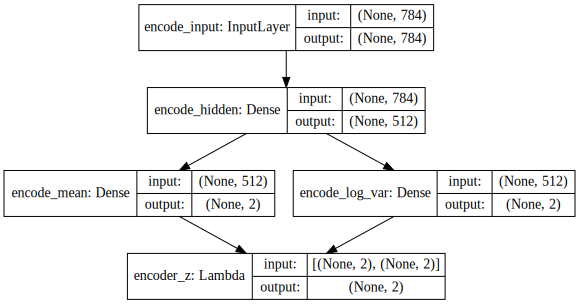

In [12]:
SVG(model_to_dot(encoder,show_shapes=True).create(prog='dot', format='svg'))

## Define a Decoder
* ###  the struct is Z---->H1---->Xhat 

In [102]:
def vae_decoder(n_x=784,n_h=512,n_z=2):
    '''
        n_x:the shape(dims) of reconstruct Image
        n_h:hidden Units
        n_z:latent dims
        return:a model with outputs is reconstruct Image
    '''
    Z_Input=Input(shape=(n_z,),name='decoder_input')
    X=Dense(n_h,activation='relu',name='decoder_hidden',kernel_initializer='he_normal')(Z_Input)
    X=Dense(n_x,activation='sigmoid',name='decoder_reconstruct',kernel_initializer='he_normal')(X)
    
    model=Model(inputs=Z_Input,outputs=X,name='decoder')
    return model

In [128]:
decoder=vae_decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 512)               1536      
_________________________________________________________________
decoder_reconstruct (Dense)  (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


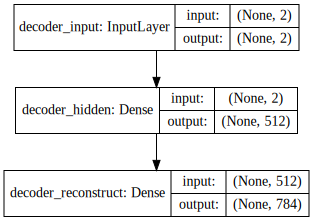

In [105]:
SVG(model_to_dot(decoder,show_shapes=True).create(prog='dot', format='svg'))

## combine Encoder and Decoder(vae_mlp)
<img src='images/vae_loss.png' />
<img src='images/vae_kl_loss.png' />

In [103]:
def vae_mlp(encoder,decoder,n_x=784):
    '''
        encoder: X(784)---->[uz,logvar_z,z]
        decoder:Z(2)-------->Xhat(784)
        
        loss=(X-Xhat)**2+KL{ qz|x |N(0,I)}
        notice Pz =N(0,I)
    '''
    
    X=Input(shape=(n_x,),name='MyInput')
    uz,logvar_z,z=encoder(X)
    Xhat=decoder(z)
    
    
    #work out the loss
    Re_loss=K.sum((X-Xhat)**2,axis=-1) #shape (?,)
    KL_loss=1+logvar_z-K.square(uz)-K.exp(logvar_z) #shape(?,n_z)
    KL_loss=-0.5*K.sum(KL_loss,axis=-1)  #shape(?,)
    loss=K.mean(Re_loss+0*KL_loss)  #shape(?)
    
    model=Model(inputs=X,outputs=Xhat)
    model.add_loss(loss)
    return model

In [107]:
vae=vae_mlp(encoder,decoder)

In [108]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MyInput (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


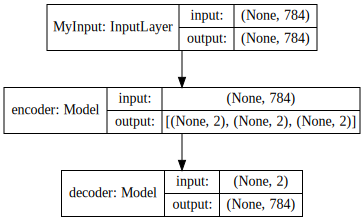

In [109]:
SVG(model_to_dot(vae,show_shapes=True).create(prog='dot', format='svg'))

In [104]:
model_path='outputs/vae.h5'
def callback():
    def myLearnRateScheduler(epoch,lr):
        print('ecpch:%d,learn rate %f'%(epoch,lr))
        return lr
    lr_scheduler=LearningRateScheduler(myLearnRateScheduler)
    checkpoint=ModelCheckpoint(model_path,monitor='val_loss',save_best_only=True,verbose=1)
    reduceOnpleateau=ReduceLROnPlateau(monitor='val_loss',min_delta=5e-5,factor=0.9,verbose=1,patience=50)
    return [lr_scheduler,checkpoint,reduceOnpleateau]

In [115]:
vae.compile(optimizer='adam')

In [116]:
batch=64
epoch=50
vae.fit(X_train,batch_size=batch,epochs=epoch,validation_data=(X_test,None),callbacks=callback())

Train on 55000 samples, validate on 10000 samples
Epoch 1/50
ecpch:0,learn rate 0.001000
55000/55000 [==============================] - 6s 115us/step - loss: 35.8559 - val_loss: 37.3411

Epoch 00001: val_loss improved from inf to 37.34110, saving model to outputs/vae.h5
Epoch 2/50
ecpch:1,learn rate 0.001000
55000/55000 [==============================] - 5s 99us/step - loss: 35.8565 - val_loss: 37.4887

Epoch 00002: val_loss did not improve from 37.34110
Epoch 3/50
ecpch:2,learn rate 0.001000
55000/55000 [==============================] - 6s 101us/step - loss: 35.8222 - val_loss: 37.4341

Epoch 00003: val_loss did not improve from 37.34110
Epoch 4/50
ecpch:3,learn rate 0.001000
55000/55000 [==============================] - 6s 103us/step - loss: 35.8506 - val_loss: 37.5229

Epoch 00004: val_loss did not improve from 37.34110
Epoch 5/50
ecpch:4,learn rate 0.001000
55000/55000 [==============================] - 6s 104us/step - loss: 35.8092 - val_loss: 37.3337

Epoch 00005: val_loss impr


Epoch 00040: val_loss did not improve from 37.13846
Epoch 41/50
ecpch:40,learn rate 0.000656
55000/55000 [==============================] - 6s 102us/step - loss: 35.2129 - val_loss: 37.1947

Epoch 00041: val_loss did not improve from 37.13846
Epoch 42/50
ecpch:41,learn rate 0.000656
55000/55000 [==============================] - 5s 95us/step - loss: 35.2120 - val_loss: 37.1920

Epoch 00042: val_loss did not improve from 37.13846
Epoch 43/50
ecpch:42,learn rate 0.000656
55000/55000 [==============================] - 5s 98us/step - loss: 35.1922 - val_loss: 37.1770

Epoch 00043: val_loss did not improve from 37.13846
Epoch 44/50
ecpch:43,learn rate 0.000656
55000/55000 [==============================] - 7s 120us/step - loss: 35.1858 - val_loss: 37.2018

Epoch 00044: val_loss did not improve from 37.13846

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 45/50
ecpch:44,learn rate 0.000590
55000/55000 [==============================] - 7s 119us/step - 

In [ ]:
## save or load model

In [117]:
encoder_path='outputs/vae_encoder'
decoder_path='outputs/vae_decoder'
encoder.save(encoder_path)
decoder.save(decoder_path)

In [132]:
encoder=load_model(encoder_path,custom_objects={'tf':tf})
decoder=load_model(decoder_path,custom_objects={'tf':tf})

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## View the distribution of Data

In [77]:
def plot_distribution(encoder,X,Y):
    plt.rcParams['figure.figsize']=(15,15)
    plt.rcParams['image.cmap']='hsv'
    Z=encoder.predict(X,batch_size=512)[0]
    plt.scatter(Z[:,0],Z[:,1],c=Y)
    plt.colorbar()
plot_distribution(encoder,X_test,Y_test)

NameError: name 'encoder' is not defined

## view how letent z affect Image 

In [78]:
def plot_model(decoder,n=15,dim=28,reshaper=None,channels=1):
    '''
        using decoder to generate image
        n:is num per axis
        dim:one image size
    '''
    plt.rcParams['figure.figsize']=(15,15)
    xrange=np.linspace(-4,4,n)
    yrange=np.linspace(4,-4,n)
    zx,zy=np.meshgrid(xrange,yrange)

    z=np.stack([zx.ravel(),zy.ravel()],axis=1) #shape[10000,2]
    I=reshaper(decoder.predict(z))
    F=np.zeros((n*dim,n*dim,channels),dtype=np.float32)
    F=np.squeeze(F)
    for i in range(n):
        for j in range(n):
            F[i*dim:i*dim+dim,j*dim:j*dim+dim]=I[i*n+j]
    xlabels=np.round(xrange,2)
    ylabels=np.round(yrange,2)
    xloc=np.arange(dim//2,dim*n+dim//2,dim)
    yloc=xloc.copy()
    plt.xticks(xloc,xlabels,size='large',rotation=45)
    plt.yticks(yloc,ylabels,size='large',rotation=45)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.imshow(F)


In [ ]:
plot_model(decoder,n=15,dim=28,reshaper=reshaper)

### Now Try Cifar10 set

In [105]:
from cifar.CIFAR10Utils import load_dataset

In [106]:
X_train,Y_train,X_test,Y_test,_=load_dataset(flaten=True,one_hot=False,filename='../AI_database/cifar/CIFAR10_DATA')


-------------------------------------------------------------------------
load 50000 train Example,10000 Test Example
Train Images  Shape:(50000, 3072)
Train Labels  Shape:(50000,)
Test  Images  Shape:(10000, 3072)
Test  Labels  Shape:(10000,)
-------------------------------------------------------------------------


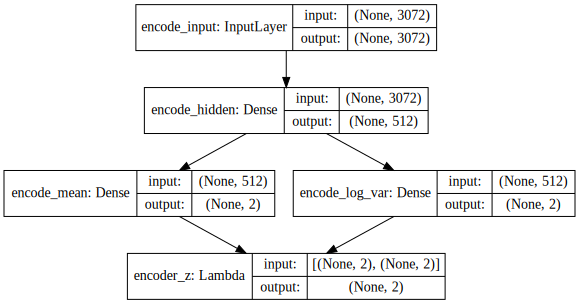

In [107]:
encoder_cifar=vae_encoder(n_x=3072,n_h=512,n_z=2)
SVG(model_to_dot(encoder_cifar,show_shapes=True).create(prog='dot', format='svg'))

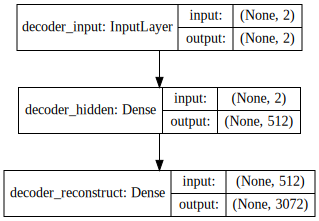

In [108]:
decoder_cifar=vae_decoder(n_x=3072,n_h=512,n_z=2)
SVG(model_to_dot(decoder_cifar,show_shapes=True).create(prog='dot', format='svg'))

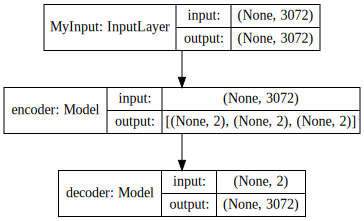

In [109]:
vae_cifar=vae_mlp(encoder_cifar,decoder_cifar,n_x=3072)
SVG(model_to_dot(vae_cifar,show_shapes=True).create(prog='dot', format='svg'))

In [120]:
vae_cifar.compile(optimizer=Adam(4e-4))
gen=ImageDataGenerator(
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True,
    zoom_range=[0.5,1.0],  #<1 mean zoom in,>1 zoom out  
    rescale=1.0   ,  #mul image by rescale
#     zca_whitening=True,
#     zca_epsilon=0.1
).flow(X_train.reshape(-1,32,32,3),None)
def myGen(gen):
    while True:
        x=next(gen)
        x=x.reshape(-1,3*32*32)
        yield (x,None)
generator=myGen(gen)

In [122]:
batch=64
epoch=5000

vae_cifar.fit(X_train[0:64],batch_size=batch,epochs=epoch,validation_data=(X_test,None),callbacks=callback())
# vae_cifar.fit_generator(generator,epochs=epoch,steps_per_epoch=50000//batch,
#                         validation_data=(X_test,None),callbacks=callback())

Train on 64 samples, validate on 10000 samples
Epoch 1/5000
ecpch:0,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 77.7312 - val_loss: 179.7857

Epoch 00001: val_loss improved from inf to 179.78574, saving model to outputs/vae.h5
Epoch 2/5000
ecpch:1,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 72.0980 - val_loss: 180.9243

Epoch 00002: val_loss did not improve from 179.78574
Epoch 3/5000
ecpch:2,learn rate 0.000400
64/64 [==============================] - 1s 10ms/step - loss: 78.1041 - val_loss: 181.0259

Epoch 00003: val_loss did not improve from 179.78574
Epoch 4/5000
ecpch:3,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 77.7417 - val_loss: 180.2452

Epoch 00004: val_loss did not improve from 179.78574
Epoch 5/5000
ecpch:4,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 71.6789 - val_loss: 180.4312

Epoch 00005: val_loss did not improve from 179.7

64/64 [==============================] - 1s 9ms/step - loss: 69.9565 - val_loss: 180.0837

Epoch 00044: val_loss did not improve from 179.48197
Epoch 45/5000
ecpch:44,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 69.8192 - val_loss: 180.4677

Epoch 00045: val_loss did not improve from 179.48197
Epoch 46/5000
ecpch:45,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 69.8974 - val_loss: 180.3681

Epoch 00046: val_loss did not improve from 179.48197
Epoch 47/5000
ecpch:46,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 69.7727 - val_loss: 180.0648

Epoch 00047: val_loss did not improve from 179.48197
Epoch 48/5000
ecpch:47,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 69.8483 - val_loss: 180.2307

Epoch 00048: val_loss did not improve from 179.48197
Epoch 49/5000
ecpch:48,learn rate 0.000400
64/64 [==============================] - 1s 9ms/step - loss: 69.7


Epoch 00087: val_loss did not improve from 179.48197
Epoch 88/5000
ecpch:87,learn rate 0.000360
64/64 [==============================] - 1s 8ms/step - loss: 69.1238 - val_loss: 181.0040

Epoch 00088: val_loss did not improve from 179.48197
Epoch 89/5000
ecpch:88,learn rate 0.000360
64/64 [==============================] - 1s 8ms/step - loss: 69.1352 - val_loss: 181.2511

Epoch 00089: val_loss did not improve from 179.48197
Epoch 90/5000
ecpch:89,learn rate 0.000360
64/64 [==============================] - 1s 8ms/step - loss: 69.1227 - val_loss: 180.9687

Epoch 00090: val_loss did not improve from 179.48197
Epoch 91/5000
ecpch:90,learn rate 0.000360
64/64 [==============================] - 1s 9ms/step - loss: 69.1096 - val_loss: 181.2639

Epoch 00091: val_loss did not improve from 179.48197
Epoch 92/5000
ecpch:91,learn rate 0.000360
64/64 [==============================] - 1s 9ms/step - loss: 69.0694 - val_loss: 181.0810

Epoch 00092: val_loss did not improve from 179.48197
Epoch 93/50

64/64 [==============================] - 1s 9ms/step - loss: 68.4382 - val_loss: 182.0260

Epoch 00131: val_loss did not improve from 179.48197
Epoch 132/5000
ecpch:131,learn rate 0.000324
64/64 [==============================] - 1s 9ms/step - loss: 68.4122 - val_loss: 181.8606

Epoch 00132: val_loss did not improve from 179.48197
Epoch 133/5000
ecpch:132,learn rate 0.000324
64/64 [==============================] - 1s 9ms/step - loss: 68.4088 - val_loss: 182.0904

Epoch 00133: val_loss did not improve from 179.48197
Epoch 134/5000
ecpch:133,learn rate 0.000324
64/64 [==============================] - 1s 9ms/step - loss: 68.3994 - val_loss: 181.8002

Epoch 00134: val_loss did not improve from 179.48197
Epoch 135/5000
ecpch:134,learn rate 0.000324
64/64 [==============================] - 1s 9ms/step - loss: 68.4623 - val_loss: 182.2901

Epoch 00135: val_loss did not improve from 179.48197
Epoch 136/5000
ecpch:135,learn rate 0.000324
64/64 [==============================] - 1s 9ms/step - 

64/64 [==============================] - 1s 10ms/step - loss: 67.7411 - val_loss: 182.7564

Epoch 00174: val_loss did not improve from 179.48197
Epoch 175/5000
ecpch:174,learn rate 0.000292
64/64 [==============================] - 1s 9ms/step - loss: 67.7189 - val_loss: 182.6101

Epoch 00175: val_loss did not improve from 179.48197
Epoch 176/5000
ecpch:175,learn rate 0.000292
64/64 [==============================] - 1s 8ms/step - loss: 67.7108 - val_loss: 182.9186

Epoch 00176: val_loss did not improve from 179.48197
Epoch 177/5000
ecpch:176,learn rate 0.000292
64/64 [==============================] - 1s 9ms/step - loss: 67.7107 - val_loss: 182.5470

Epoch 00177: val_loss did not improve from 179.48197
Epoch 178/5000
ecpch:177,learn rate 0.000292
64/64 [==============================] - 0s 8ms/step - loss: 67.7420 - val_loss: 182.9941

Epoch 00178: val_loss did not improve from 179.48197
Epoch 179/5000
ecpch:178,learn rate 0.000292
64/64 [==============================] - 1s 9ms/step -

64/64 [==============================] - 1s 9ms/step - loss: 67.0293 - val_loss: 183.7044

Epoch 00217: val_loss did not improve from 179.48197
Epoch 218/5000
ecpch:217,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - loss: 67.0919 - val_loss: 183.1432

Epoch 00218: val_loss did not improve from 179.48197
Epoch 219/5000
ecpch:218,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - loss: 67.1200 - val_loss: 183.6947

Epoch 00219: val_loss did not improve from 179.48197
Epoch 220/5000
ecpch:219,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - loss: 67.0519 - val_loss: 183.3544

Epoch 00220: val_loss did not improve from 179.48197
Epoch 221/5000
ecpch:220,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - loss: 67.0339 - val_loss: 183.5870

Epoch 00221: val_loss did not improve from 179.48197
Epoch 222/5000
ecpch:221,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - 


Epoch 00260: val_loss did not improve from 179.48197
Epoch 261/5000
ecpch:260,learn rate 0.000262
64/64 [==============================] - 1s 9ms/step - loss: 66.3828 - val_loss: 184.3640

Epoch 00261: val_loss did not improve from 179.48197
Epoch 262/5000
ecpch:261,learn rate 0.000262
64/64 [==============================] - 1s 10ms/step - loss: 66.3322 - val_loss: 184.0439

Epoch 00262: val_loss did not improve from 179.48197
Epoch 263/5000
ecpch:262,learn rate 0.000262
64/64 [==============================] - 1s 10ms/step - loss: 66.3354 - val_loss: 184.3938

Epoch 00263: val_loss did not improve from 179.48197

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.00023619600688107312.
Epoch 264/5000
ecpch:263,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss: 66.3236 - val_loss: 184.0933

Epoch 00264: val_loss did not improve from 179.48197
Epoch 265/5000
ecpch:264,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss


Epoch 00303: val_loss did not improve from 179.48197
Epoch 304/5000
ecpch:303,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss: 65.7597 - val_loss: 184.4902

Epoch 00304: val_loss did not improve from 179.48197
Epoch 305/5000
ecpch:304,learn rate 0.000236
64/64 [==============================] - 1s 9ms/step - loss: 65.7757 - val_loss: 185.0975

Epoch 00305: val_loss did not improve from 179.48197
Epoch 306/5000
ecpch:305,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss: 65.7004 - val_loss: 184.6431

Epoch 00306: val_loss did not improve from 179.48197
Epoch 307/5000
ecpch:306,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss: 65.6518 - val_loss: 185.0224

Epoch 00307: val_loss did not improve from 179.48197
Epoch 308/5000
ecpch:307,learn rate 0.000236
64/64 [==============================] - 1s 10ms/step - loss: 65.5928 - val_loss: 184.8739

Epoch 00308: val_loss did not improve from 179.481


Epoch 00346: val_loss did not improve from 179.48197
Epoch 347/5000
ecpch:346,learn rate 0.000213
64/64 [==============================] - 1s 10ms/step - loss: 65.0430 - val_loss: 185.2275

Epoch 00347: val_loss did not improve from 179.48197
Epoch 348/5000
ecpch:347,learn rate 0.000213
64/64 [==============================] - 1s 10ms/step - loss: 65.1221 - val_loss: 185.8226

Epoch 00348: val_loss did not improve from 179.48197
Epoch 349/5000
ecpch:348,learn rate 0.000213
64/64 [==============================] - 1s 10ms/step - loss: 65.1376 - val_loss: 185.2729

Epoch 00349: val_loss did not improve from 179.48197
Epoch 350/5000
ecpch:349,learn rate 0.000213
64/64 [==============================] - 1s 10ms/step - loss: 65.1450 - val_loss: 185.7339

Epoch 00350: val_loss did not improve from 179.48197
Epoch 351/5000
ecpch:350,learn rate 0.000213
64/64 [==============================] - 1s 9ms/step - loss: 64.9995 - val_loss: 185.3611

Epoch 00351: val_loss did not improve from 179.481


Epoch 00389: val_loss did not improve from 179.48197
Epoch 390/5000
ecpch:389,learn rate 0.000191
64/64 [==============================] - 1s 9ms/step - loss: 64.4359 - val_loss: 185.8760

Epoch 00390: val_loss did not improve from 179.48197
Epoch 391/5000
ecpch:390,learn rate 0.000191
64/64 [==============================] - 1s 10ms/step - loss: 64.3892 - val_loss: 186.1312

Epoch 00391: val_loss did not improve from 179.48197
Epoch 392/5000
ecpch:391,learn rate 0.000191
64/64 [==============================] - 1s 10ms/step - loss: 64.3263 - val_loss: 186.0443

Epoch 00392: val_loss did not improve from 179.48197
Epoch 393/5000
ecpch:392,learn rate 0.000191
64/64 [==============================] - 1s 10ms/step - loss: 64.3032 - val_loss: 186.1656

Epoch 00393: val_loss did not improve from 179.48197
Epoch 394/5000
ecpch:393,learn rate 0.000191
64/64 [==============================] - 1s 10ms/step - loss: 64.2985 - val_loss: 186.0112

Epoch 00394: val_loss did not improve from 179.481


Epoch 00432: val_loss did not improve from 179.48197
Epoch 433/5000
ecpch:432,learn rate 0.000172
64/64 [==============================] - 1s 10ms/step - loss: 63.7821 - val_loss: 186.5001

Epoch 00433: val_loss did not improve from 179.48197
Epoch 434/5000
ecpch:433,learn rate 0.000172
64/64 [==============================] - 1s 9ms/step - loss: 63.7676 - val_loss: 186.7613

Epoch 00434: val_loss did not improve from 179.48197
Epoch 435/5000
ecpch:434,learn rate 0.000172
64/64 [==============================] - 1s 10ms/step - loss: 63.7321 - val_loss: 186.5345

Epoch 00435: val_loss did not improve from 179.48197
Epoch 436/5000
ecpch:435,learn rate 0.000172
64/64 [==============================] - 1s 10ms/step - loss: 63.7312 - val_loss: 186.8269

Epoch 00436: val_loss did not improve from 179.48197
Epoch 437/5000
ecpch:436,learn rate 0.000172
64/64 [==============================] - 1s 10ms/step - loss: 63.7300 - val_loss: 186.4719

Epoch 00437: val_loss did not improve from 179.481


Epoch 00475: val_loss did not improve from 179.48197
Epoch 476/5000
ecpch:475,learn rate 0.000155
64/64 [==============================] - 1s 10ms/step - loss: 63.2010 - val_loss: 187.3575

Epoch 00476: val_loss did not improve from 179.48197
Epoch 477/5000
ecpch:476,learn rate 0.000155
64/64 [==============================] - 1s 9ms/step - loss: 63.3151 - val_loss: 186.9691

Epoch 00477: val_loss did not improve from 179.48197
Epoch 478/5000
ecpch:477,learn rate 0.000155
64/64 [==============================] - 1s 10ms/step - loss: 63.3170 - val_loss: 187.3641

Epoch 00478: val_loss did not improve from 179.48197
Epoch 479/5000
ecpch:478,learn rate 0.000155
64/64 [==============================] - 1s 10ms/step - loss: 63.1823 - val_loss: 187.0422

Epoch 00479: val_loss did not improve from 179.48197
Epoch 480/5000
ecpch:479,learn rate 0.000155
64/64 [==============================] - 1s 10ms/step - loss: 63.2635 - val_loss: 187.1953

Epoch 00480: val_loss did not improve from 179.481


Epoch 00518: val_loss did not improve from 179.48197
Epoch 519/5000
ecpch:518,learn rate 0.000139
64/64 [==============================] - 1s 9ms/step - loss: 62.8668 - val_loss: 187.3619

Epoch 00519: val_loss did not improve from 179.48197
Epoch 520/5000
ecpch:519,learn rate 0.000139
64/64 [==============================] - 1s 9ms/step - loss: 62.8474 - val_loss: 188.1292

Epoch 00520: val_loss did not improve from 179.48197
Epoch 521/5000
ecpch:520,learn rate 0.000139
64/64 [==============================] - 1s 9ms/step - loss: 62.9584 - val_loss: 187.6488

Epoch 00521: val_loss did not improve from 179.48197
Epoch 522/5000
ecpch:521,learn rate 0.000139
64/64 [==============================] - 1s 9ms/step - loss: 62.6837 - val_loss: 187.4026

Epoch 00522: val_loss did not improve from 179.48197
Epoch 523/5000
ecpch:522,learn rate 0.000139
64/64 [==============================] - 1s 9ms/step - loss: 62.7856 - val_loss: 188.0253

Epoch 00523: val_loss did not improve from 179.48197
E

64/64 [==============================] - 1s 10ms/step - loss: 62.2087 - val_loss: 187.7993

Epoch 00562: val_loss did not improve from 179.48197
Epoch 563/5000
ecpch:562,learn rate 0.000139
64/64 [==============================] - 1s 10ms/step - loss: 62.3745 - val_loss: 188.3355

Epoch 00563: val_loss did not improve from 179.48197

Epoch 00563: ReduceLROnPlateau reducing learning rate to 0.00012552423868328333.
Epoch 564/5000
ecpch:563,learn rate 0.000126
64/64 [==============================] - 1s 10ms/step - loss: 62.1474 - val_loss: 188.2308

Epoch 00564: val_loss did not improve from 179.48197
Epoch 565/5000
ecpch:564,learn rate 0.000126
64/64 [==============================] - 1s 10ms/step - loss: 62.1073 - val_loss: 187.9941

Epoch 00565: val_loss did not improve from 179.48197
Epoch 566/5000
ecpch:565,learn rate 0.000126
64/64 [==============================] - 1s 9ms/step - loss: 62.2420 - val_loss: 188.3285

Epoch 00566: val_loss did not improve from 179.48197
Epoch 567/5000

64/64 [==============================] - 1s 10ms/step - loss: 61.6850 - val_loss: 188.6671

Epoch 00605: val_loss did not improve from 179.48197
Epoch 606/5000
ecpch:605,learn rate 0.000126
64/64 [==============================] - 1s 9ms/step - loss: 61.7358 - val_loss: 188.3833

Epoch 00606: val_loss did not improve from 179.48197
Epoch 607/5000
ecpch:606,learn rate 0.000126
64/64 [==============================] - 1s 9ms/step - loss: 61.6932 - val_loss: 188.7093

Epoch 00607: val_loss did not improve from 179.48197
Epoch 608/5000
ecpch:607,learn rate 0.000126
64/64 [==============================] - 1s 10ms/step - loss: 61.6656 - val_loss: 188.5190

Epoch 00608: val_loss did not improve from 179.48197
Epoch 609/5000
ecpch:608,learn rate 0.000126
64/64 [==============================] - 1s 9ms/step - loss: 61.7127 - val_loss: 188.6020

Epoch 00609: val_loss did not improve from 179.48197
Epoch 610/5000
ecpch:609,learn rate 0.000126
64/64 [==============================] - 1s 9ms/step 

64/64 [==============================] - 1s 9ms/step - loss: 61.2124 - val_loss: 189.0710

Epoch 00648: val_loss did not improve from 179.48197
Epoch 649/5000
ecpch:648,learn rate 0.000113
64/64 [==============================] - 1s 9ms/step - loss: 61.2211 - val_loss: 188.7272

Epoch 00649: val_loss did not improve from 179.48197
Epoch 650/5000
ecpch:649,learn rate 0.000113
64/64 [==============================] - 1s 10ms/step - loss: 61.2824 - val_loss: 189.0968

Epoch 00650: val_loss did not improve from 179.48197
Epoch 651/5000
ecpch:650,learn rate 0.000113
64/64 [==============================] - 1s 10ms/step - loss: 61.2031 - val_loss: 188.8475

Epoch 00651: val_loss did not improve from 179.48197
Epoch 652/5000
ecpch:651,learn rate 0.000113
64/64 [==============================] - 1s 10ms/step - loss: 61.1769 - val_loss: 189.0519

Epoch 00652: val_loss did not improve from 179.48197
Epoch 653/5000
ecpch:652,learn rate 0.000113
64/64 [==============================] - 1s 10ms/ste

64/64 [==============================] - 1s 10ms/step - loss: 60.7768 - val_loss: 189.1423

Epoch 00691: val_loss did not improve from 179.48197
Epoch 692/5000
ecpch:691,learn rate 0.000102
64/64 [==============================] - 1s 10ms/step - loss: 61.0146 - val_loss: 189.3448

Epoch 00692: val_loss did not improve from 179.48197
Epoch 693/5000
ecpch:692,learn rate 0.000102
64/64 [==============================] - 1s 10ms/step - loss: 60.7583 - val_loss: 189.5131

Epoch 00693: val_loss did not improve from 179.48197
Epoch 694/5000
ecpch:693,learn rate 0.000102
64/64 [==============================] - 1s 10ms/step - loss: 60.8356 - val_loss: 189.0774

Epoch 00694: val_loss did not improve from 179.48197
Epoch 695/5000
ecpch:694,learn rate 0.000102
64/64 [==============================] - 1s 9ms/step - loss: 61.0009 - val_loss: 189.3749

Epoch 00695: val_loss did not improve from 179.48197
Epoch 696/5000
ecpch:695,learn rate 0.000102
64/64 [==============================] - 1s 9ms/ste

64/64 [==============================] - 1s 10ms/step - loss: 60.4063 - val_loss: 189.4486

Epoch 00734: val_loss did not improve from 179.48197
Epoch 735/5000
ecpch:734,learn rate 0.000092
64/64 [==============================] - 1s 9ms/step - loss: 60.4944 - val_loss: 189.6977

Epoch 00735: val_loss did not improve from 179.48197
Epoch 736/5000
ecpch:735,learn rate 0.000092
64/64 [==============================] - 1s 9ms/step - loss: 60.3699 - val_loss: 189.7659

Epoch 00736: val_loss did not improve from 179.48197
Epoch 737/5000
ecpch:736,learn rate 0.000092
64/64 [==============================] - 1s 10ms/step - loss: 60.3695 - val_loss: 189.4119

Epoch 00737: val_loss did not improve from 179.48197
Epoch 738/5000
ecpch:737,learn rate 0.000092
64/64 [==============================] - 1s 9ms/step - loss: 60.5306 - val_loss: 189.7391

Epoch 00738: val_loss did not improve from 179.48197
Epoch 739/5000
ecpch:738,learn rate 0.000092
64/64 [==============================] - 1s 10ms/step

64/64 [==============================] - 1s 9ms/step - loss: 60.0248 - val_loss: 189.8483

Epoch 00777: val_loss did not improve from 179.48197
Epoch 778/5000
ecpch:777,learn rate 0.000082
64/64 [==============================] - 1s 10ms/step - loss: 60.0876 - val_loss: 190.1036

Epoch 00778: val_loss did not improve from 179.48197
Epoch 779/5000
ecpch:778,learn rate 0.000082
64/64 [==============================] - 1s 9ms/step - loss: 60.0004 - val_loss: 190.0589

Epoch 00779: val_loss did not improve from 179.48197
Epoch 780/5000
ecpch:779,learn rate 0.000082
64/64 [==============================] - 1s 9ms/step - loss: 59.9995 - val_loss: 189.9690

Epoch 00780: val_loss did not improve from 179.48197
Epoch 781/5000
ecpch:780,learn rate 0.000082
64/64 [==============================] - 1s 9ms/step - loss: 59.9971 - val_loss: 190.0718

Epoch 00781: val_loss did not improve from 179.48197
Epoch 782/5000
ecpch:781,learn rate 0.000082
64/64 [==============================] - 1s 10ms/step 

64/64 [==============================] - 1s 10ms/step - loss: 59.6557 - val_loss: 190.2856

Epoch 00820: val_loss did not improve from 179.48197
Epoch 821/5000
ecpch:820,learn rate 0.000074
64/64 [==============================] - 1s 9ms/step - loss: 59.6513 - val_loss: 190.4276

Epoch 00821: val_loss did not improve from 179.48197
Epoch 822/5000
ecpch:821,learn rate 0.000074
64/64 [==============================] - 1s 9ms/step - loss: 59.6583 - val_loss: 190.3146

Epoch 00822: val_loss did not improve from 179.48197
Epoch 823/5000
ecpch:822,learn rate 0.000074
64/64 [==============================] - 1s 9ms/step - loss: 59.6832 - val_loss: 190.4156

Epoch 00823: val_loss did not improve from 179.48197
Epoch 824/5000
ecpch:823,learn rate 0.000074
64/64 [==============================] - 1s 9ms/step - loss: 59.6208 - val_loss: 190.3648

Epoch 00824: val_loss did not improve from 179.48197
Epoch 825/5000
ecpch:824,learn rate 0.000074
64/64 [==============================] - 1s 9ms/step -


Epoch 00863: val_loss did not improve from 179.48197

Epoch 00863: ReduceLROnPlateau reducing learning rate to 6.670872535323724e-05.
Epoch 864/5000
ecpch:863,learn rate 0.000067
64/64 [==============================] - 1s 9ms/step - loss: 59.3439 - val_loss: 190.5561

Epoch 00864: val_loss did not improve from 179.48197
Epoch 865/5000
ecpch:864,learn rate 0.000067
64/64 [==============================] - 1s 11ms/step - loss: 59.3237 - val_loss: 190.6932

Epoch 00865: val_loss did not improve from 179.48197
Epoch 866/5000
ecpch:865,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss: 59.3106 - val_loss: 190.6352

Epoch 00866: val_loss did not improve from 179.48197
Epoch 867/5000
ecpch:866,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss: 59.3080 - val_loss: 190.6526

Epoch 00867: val_loss did not improve from 179.48197
Epoch 868/5000
ecpch:867,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss:


Epoch 00906: val_loss did not improve from 179.48197
Epoch 907/5000
ecpch:906,learn rate 0.000067
64/64 [==============================] - 1s 9ms/step - loss: 59.1470 - val_loss: 190.8940

Epoch 00907: val_loss did not improve from 179.48197
Epoch 908/5000
ecpch:907,learn rate 0.000067
64/64 [==============================] - 1s 9ms/step - loss: 59.0006 - val_loss: 190.8136

Epoch 00908: val_loss did not improve from 179.48197
Epoch 909/5000
ecpch:908,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss: 59.0921 - val_loss: 190.9867

Epoch 00909: val_loss did not improve from 179.48197
Epoch 910/5000
ecpch:909,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss: 59.0521 - val_loss: 190.8163

Epoch 00910: val_loss did not improve from 179.48197
Epoch 911/5000
ecpch:910,learn rate 0.000067
64/64 [==============================] - 1s 10ms/step - loss: 59.0015 - val_loss: 190.9323

Epoch 00911: val_loss did not improve from 179.4819


Epoch 00949: val_loss did not improve from 179.48197
Epoch 950/5000
ecpch:949,learn rate 0.000060
64/64 [==============================] - 1s 10ms/step - loss: 58.7951 - val_loss: 191.2299

Epoch 00950: val_loss did not improve from 179.48197
Epoch 951/5000
ecpch:950,learn rate 0.000060
64/64 [==============================] - 1s 10ms/step - loss: 58.7457 - val_loss: 191.0096

Epoch 00951: val_loss did not improve from 179.48197
Epoch 952/5000
ecpch:951,learn rate 0.000060
64/64 [==============================] - 1s 10ms/step - loss: 58.8700 - val_loss: 191.1585

Epoch 00952: val_loss did not improve from 179.48197
Epoch 953/5000
ecpch:952,learn rate 0.000060
64/64 [==============================] - 1s 10ms/step - loss: 58.7108 - val_loss: 191.4248

Epoch 00953: val_loss did not improve from 179.48197
Epoch 954/5000
ecpch:953,learn rate 0.000060
64/64 [==============================] - 1s 10ms/step - loss: 58.9271 - val_loss: 191.1285

Epoch 00954: val_loss did not improve from 179.48


Epoch 00992: val_loss did not improve from 179.48197
Epoch 993/5000
ecpch:992,learn rate 0.000054
64/64 [==============================] - 1s 11ms/step - loss: 58.4940 - val_loss: 191.3190

Epoch 00993: val_loss did not improve from 179.48197
Epoch 994/5000
ecpch:993,learn rate 0.000054
64/64 [==============================] - 1s 10ms/step - loss: 58.4895 - val_loss: 191.4620

Epoch 00994: val_loss did not improve from 179.48197
Epoch 995/5000
ecpch:994,learn rate 0.000054
64/64 [==============================] - 1s 9ms/step - loss: 58.4702 - val_loss: 191.3266

Epoch 00995: val_loss did not improve from 179.48197
Epoch 996/5000
ecpch:995,learn rate 0.000054
64/64 [==============================] - 1s 9ms/step - loss: 58.4784 - val_loss: 191.4323

Epoch 00996: val_loss did not improve from 179.48197
Epoch 997/5000
ecpch:996,learn rate 0.000054
64/64 [==============================] - 1s 9ms/step - loss: 58.4557 - val_loss: 191.3678

Epoch 00997: val_loss did not improve from 179.48197

64/64 [==============================] - 1s 10ms/step - loss: 58.2304 - val_loss: 191.6317

Epoch 01035: val_loss did not improve from 179.48197
Epoch 1036/5000
ecpch:1035,learn rate 0.000049
64/64 [==============================] - 1s 10ms/step - loss: 58.2587 - val_loss: 191.5763

Epoch 01036: val_loss did not improve from 179.48197
Epoch 1037/5000
ecpch:1036,learn rate 0.000049
64/64 [==============================] - 1s 10ms/step - loss: 58.2634 - val_loss: 191.6686

Epoch 01037: val_loss did not improve from 179.48197
Epoch 1038/5000
ecpch:1037,learn rate 0.000049
64/64 [==============================] - 1s 10ms/step - loss: 58.2153 - val_loss: 191.5447

Epoch 01038: val_loss did not improve from 179.48197
Epoch 1039/5000
ecpch:1038,learn rate 0.000049
64/64 [==============================] - 1s 10ms/step - loss: 58.2581 - val_loss: 191.6904

Epoch 01039: val_loss did not improve from 179.48197
Epoch 1040/5000
ecpch:1039,learn rate 0.000049
64/64 [==============================] -


Epoch 01077: val_loss did not improve from 179.48197
Epoch 1078/5000
ecpch:1077,learn rate 0.000044
64/64 [==============================] - 1s 9ms/step - loss: 58.0881 - val_loss: 191.7573

Epoch 01078: val_loss did not improve from 179.48197
Epoch 1079/5000
ecpch:1078,learn rate 0.000044
64/64 [==============================] - 1s 10ms/step - loss: 58.0273 - val_loss: 191.7832

Epoch 01079: val_loss did not improve from 179.48197
Epoch 1080/5000
ecpch:1079,learn rate 0.000044
64/64 [==============================] - 1s 10ms/step - loss: 58.0732 - val_loss: 191.8571

Epoch 01080: val_loss did not improve from 179.48197
Epoch 1081/5000
ecpch:1080,learn rate 0.000044
64/64 [==============================] - 1s 11ms/step - loss: 58.0146 - val_loss: 191.7526

Epoch 01081: val_loss did not improve from 179.48197
Epoch 1082/5000
ecpch:1081,learn rate 0.000044
64/64 [==============================] - 1s 10ms/step - loss: 58.0725 - val_loss: 191.8184

Epoch 01082: val_loss did not improve fr

64/64 [==============================] - 1s 9ms/step - loss: 57.8207 - val_loss: 191.9780

Epoch 01120: val_loss did not improve from 179.48197
Epoch 1121/5000
ecpch:1120,learn rate 0.000039
64/64 [==============================] - 1s 9ms/step - loss: 57.8158 - val_loss: 192.0574

Epoch 01121: val_loss did not improve from 179.48197
Epoch 1122/5000
ecpch:1121,learn rate 0.000039
64/64 [==============================] - 1s 10ms/step - loss: 57.8161 - val_loss: 191.9050

Epoch 01122: val_loss did not improve from 179.48197
Epoch 1123/5000
ecpch:1122,learn rate 0.000039
64/64 [==============================] - 1s 10ms/step - loss: 57.8429 - val_loss: 191.9565

Epoch 01123: val_loss did not improve from 179.48197
Epoch 1124/5000
ecpch:1123,learn rate 0.000039
64/64 [==============================] - 1s 10ms/step - loss: 57.7864 - val_loss: 192.1187

Epoch 01124: val_loss did not improve from 179.48197
Epoch 1125/5000
ecpch:1124,learn rate 0.000039
64/64 [==============================] - 1

64/64 [==============================] - 1s 9ms/step - loss: 57.6288 - val_loss: 192.1216

Epoch 01163: val_loss did not improve from 179.48197

Epoch 01163: ReduceLROnPlateau reducing learning rate to 3.5451750591164455e-05.
Epoch 1164/5000
ecpch:1163,learn rate 0.000035
64/64 [==============================] - 1s 10ms/step - loss: 57.6007 - val_loss: 192.1403

Epoch 01164: val_loss did not improve from 179.48197
Epoch 1165/5000
ecpch:1164,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.6037 - val_loss: 192.2254

Epoch 01165: val_loss did not improve from 179.48197
Epoch 1166/5000
ecpch:1165,learn rate 0.000035
64/64 [==============================] - 1s 10ms/step - loss: 57.6213 - val_loss: 192.0947

Epoch 01166: val_loss did not improve from 179.48197
Epoch 1167/5000
ecpch:1166,learn rate 0.000035
64/64 [==============================] - 1s 10ms/step - loss: 57.6088 - val_loss: 192.1341

Epoch 01167: val_loss did not improve from 179.48197
Epoch 1


Epoch 01205: val_loss did not improve from 179.48197
Epoch 1206/5000
ecpch:1205,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.4460 - val_loss: 192.3166

Epoch 01206: val_loss did not improve from 179.48197
Epoch 1207/5000
ecpch:1206,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.4121 - val_loss: 192.3429

Epoch 01207: val_loss did not improve from 179.48197
Epoch 1208/5000
ecpch:1207,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.4199 - val_loss: 192.3286

Epoch 01208: val_loss did not improve from 179.48197
Epoch 1209/5000
ecpch:1208,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.4391 - val_loss: 192.3955

Epoch 01209: val_loss did not improve from 179.48197
Epoch 1210/5000
ecpch:1209,learn rate 0.000035
64/64 [==============================] - 1s 9ms/step - loss: 57.4113 - val_loss: 192.2807

Epoch 01210: val_loss did not improve from 1

64/64 [==============================] - 1s 9ms/step - loss: 57.2660 - val_loss: 192.4661

Epoch 01248: val_loss did not improve from 179.48197
Epoch 1249/5000
ecpch:1248,learn rate 0.000032
64/64 [==============================] - 1s 10ms/step - loss: 57.2647 - val_loss: 192.4543

Epoch 01249: val_loss did not improve from 179.48197
Epoch 1250/5000
ecpch:1249,learn rate 0.000032
64/64 [==============================] - 1s 9ms/step - loss: 57.2445 - val_loss: 192.5085

Epoch 01250: val_loss did not improve from 179.48197
Epoch 1251/5000
ecpch:1250,learn rate 0.000032
64/64 [==============================] - 1s 10ms/step - loss: 57.2480 - val_loss: 192.3807

Epoch 01251: val_loss did not improve from 179.48197
Epoch 1252/5000
ecpch:1251,learn rate 0.000032
64/64 [==============================] - 1s 10ms/step - loss: 57.2779 - val_loss: 192.4888

Epoch 01252: val_loss did not improve from 179.48197
Epoch 1253/5000
ecpch:1252,learn rate 0.000032
64/64 [==============================] - 1


Epoch 01290: val_loss did not improve from 179.48197
Epoch 1291/5000
ecpch:1290,learn rate 0.000029
64/64 [==============================] - 1s 10ms/step - loss: 57.0963 - val_loss: 192.5808

Epoch 01291: val_loss did not improve from 179.48197
Epoch 1292/5000
ecpch:1291,learn rate 0.000029
64/64 [==============================] - 1s 10ms/step - loss: 57.1322 - val_loss: 192.6365

Epoch 01292: val_loss did not improve from 179.48197
Epoch 1293/5000
ecpch:1292,learn rate 0.000029
64/64 [==============================] - 1s 10ms/step - loss: 57.0935 - val_loss: 192.6138

Epoch 01293: val_loss did not improve from 179.48197
Epoch 1294/5000
ecpch:1293,learn rate 0.000029
64/64 [==============================] - 1s 10ms/step - loss: 57.0930 - val_loss: 192.6335

Epoch 01294: val_loss did not improve from 179.48197
Epoch 1295/5000
ecpch:1294,learn rate 0.000029
64/64 [==============================] - 1s 10ms/step - loss: 57.1174 - val_loss: 192.6174

Epoch 01295: val_loss did not improve f

64/64 [==============================] - 1s 11ms/step - loss: 56.9769 - val_loss: 192.6982

Epoch 01333: val_loss did not improve from 179.48197
Epoch 1334/5000
ecpch:1333,learn rate 0.000026
64/64 [==============================] - 1s 10ms/step - loss: 57.0047 - val_loss: 192.7735

Epoch 01334: val_loss did not improve from 179.48197
Epoch 1335/5000
ecpch:1334,learn rate 0.000026
64/64 [==============================] - 1s 10ms/step - loss: 56.9812 - val_loss: 192.7027

Epoch 01335: val_loss did not improve from 179.48197
Epoch 1336/5000
ecpch:1335,learn rate 0.000026
64/64 [==============================] - 1s 9ms/step - loss: 56.9984 - val_loss: 192.6971

Epoch 01336: val_loss did not improve from 179.48197
Epoch 1337/5000
ecpch:1336,learn rate 0.000026
64/64 [==============================] - 1s 9ms/step - loss: 56.9767 - val_loss: 192.7623

Epoch 01337: val_loss did not improve from 179.48197
Epoch 1338/5000
ecpch:1337,learn rate 0.000026
64/64 [==============================] - 1


Epoch 01375: val_loss did not improve from 179.48197
Epoch 1376/5000
ecpch:1375,learn rate 0.000023
64/64 [==============================] - 1s 10ms/step - loss: 56.8402 - val_loss: 192.7975

Epoch 01376: val_loss did not improve from 179.48197
Epoch 1377/5000
ecpch:1376,learn rate 0.000023
64/64 [==============================] - 1s 10ms/step - loss: 56.8434 - val_loss: 192.8930

Epoch 01377: val_loss did not improve from 179.48197
Epoch 1378/5000
ecpch:1377,learn rate 0.000023
64/64 [==============================] - 1s 9ms/step - loss: 56.8370 - val_loss: 192.8457

Epoch 01378: val_loss did not improve from 179.48197
Epoch 1379/5000
ecpch:1378,learn rate 0.000023
64/64 [==============================] - 1s 10ms/step - loss: 56.8332 - val_loss: 192.8014

Epoch 01379: val_loss did not improve from 179.48197
Epoch 1380/5000
ecpch:1379,learn rate 0.000023
64/64 [==============================] - 1s 10ms/step - loss: 56.8228 - val_loss: 192.8628

Epoch 01380: val_loss did not improve fr

64/64 [==============================] - 1s 10ms/step - loss: 56.7194 - val_loss: 192.9620

Epoch 01418: val_loss did not improve from 179.48197
Epoch 1419/5000
ecpch:1418,learn rate 0.000021
64/64 [==============================] - 1s 9ms/step - loss: 56.6971 - val_loss: 192.8881

Epoch 01419: val_loss did not improve from 179.48197
Epoch 1420/5000
ecpch:1419,learn rate 0.000021
64/64 [==============================] - 1s 9ms/step - loss: 56.7272 - val_loss: 192.9377

Epoch 01420: val_loss did not improve from 179.48197
Epoch 1421/5000
ecpch:1420,learn rate 0.000021
64/64 [==============================] - 1s 9ms/step - loss: 56.6859 - val_loss: 193.0161

Epoch 01421: val_loss did not improve from 179.48197
Epoch 1422/5000
ecpch:1421,learn rate 0.000021
64/64 [==============================] - 1s 9ms/step - loss: 56.7170 - val_loss: 192.9526

Epoch 01422: val_loss did not improve from 179.48197
Epoch 1423/5000
ecpch:1422,learn rate 0.000021
64/64 [==============================] - 1s 

64/64 [==============================] - 1s 10ms/step - loss: 56.5835 - val_loss: 193.0334

Epoch 01461: val_loss did not improve from 179.48197
Epoch 1462/5000
ecpch:1461,learn rate 0.000021
64/64 [==============================] - 1s 10ms/step - loss: 56.5782 - val_loss: 193.0538

Epoch 01462: val_loss did not improve from 179.48197
Epoch 1463/5000
ecpch:1462,learn rate 0.000021
64/64 [==============================] - 1s 11ms/step - loss: 56.5654 - val_loss: 193.0574

Epoch 01463: val_loss did not improve from 179.48197

Epoch 01463: ReduceLROnPlateau reducing learning rate to 1.8840514530893416e-05.
Epoch 1464/5000
ecpch:1463,learn rate 0.000019
64/64 [==============================] - 1s 10ms/step - loss: 56.5600 - val_loss: 193.0506

Epoch 01464: val_loss did not improve from 179.48197
Epoch 1465/5000
ecpch:1464,learn rate 0.000019
64/64 [==============================] - 1s 9ms/step - loss: 56.5595 - val_loss: 193.0825

Epoch 01465: val_loss did not improve from 179.48197
Epoch 


Epoch 01503: val_loss did not improve from 179.48197
Epoch 1504/5000
ecpch:1503,learn rate 0.000019
64/64 [==============================] - 1s 10ms/step - loss: 56.4967 - val_loss: 193.0672

Epoch 01504: val_loss did not improve from 179.48197
Epoch 1505/5000
ecpch:1504,learn rate 0.000019
64/64 [==============================] - 1s 10ms/step - loss: 56.4860 - val_loss: 193.0970

Epoch 01505: val_loss did not improve from 179.48197
Epoch 1506/5000
ecpch:1505,learn rate 0.000019
64/64 [==============================] - 1s 10ms/step - loss: 56.5004 - val_loss: 193.1653

Epoch 01506: val_loss did not improve from 179.48197
Epoch 1507/5000
ecpch:1506,learn rate 0.000019
64/64 [==============================] - 1s 8ms/step - loss: 56.4798 - val_loss: 193.1334

Epoch 01507: val_loss did not improve from 179.48197
Epoch 1508/5000
ecpch:1507,learn rate 0.000019
64/64 [==============================] - 1s 9ms/step - loss: 56.4927 - val_loss: 193.0935

Epoch 01508: val_loss did not improve fro

64/64 [==============================] - 1s 9ms/step - loss: 56.4161 - val_loss: 193.1564

Epoch 01546: val_loss did not improve from 179.48197
Epoch 1547/5000
ecpch:1546,learn rate 0.000017
64/64 [==============================] - 1s 10ms/step - loss: 56.3930 - val_loss: 193.3026

Epoch 01547: val_loss did not improve from 179.48197
Epoch 1548/5000
ecpch:1547,learn rate 0.000017
64/64 [==============================] - 1s 11ms/step - loss: 56.4093 - val_loss: 193.2970

Epoch 01548: val_loss did not improve from 179.48197
Epoch 1549/5000
ecpch:1548,learn rate 0.000017
64/64 [==============================] - 1s 10ms/step - loss: 56.3950 - val_loss: 193.1480

Epoch 01549: val_loss did not improve from 179.48197
Epoch 1550/5000
ecpch:1549,learn rate 0.000017
64/64 [==============================] - 1s 10ms/step - loss: 56.3992 - val_loss: 193.1370

Epoch 01550: val_loss did not improve from 179.48197
Epoch 1551/5000
ecpch:1550,learn rate 0.000017
64/64 [==============================] - 


Epoch 01588: val_loss did not improve from 179.48197
Epoch 1589/5000
ecpch:1588,learn rate 0.000015
64/64 [==============================] - 1s 10ms/step - loss: 56.3258 - val_loss: 193.3283

Epoch 01589: val_loss did not improve from 179.48197
Epoch 1590/5000
ecpch:1589,learn rate 0.000015
64/64 [==============================] - 1s 9ms/step - loss: 56.2849 - val_loss: 193.1957

Epoch 01590: val_loss did not improve from 179.48197
Epoch 1591/5000
ecpch:1590,learn rate 0.000015
64/64 [==============================] - 1s 10ms/step - loss: 56.3441 - val_loss: 193.2041

Epoch 01591: val_loss did not improve from 179.48197
Epoch 1592/5000
ecpch:1591,learn rate 0.000015
64/64 [==============================] - 1s 10ms/step - loss: 56.3372 - val_loss: 193.3382

Epoch 01592: val_loss did not improve from 179.48197
Epoch 1593/5000
ecpch:1592,learn rate 0.000015
64/64 [==============================] - 1s 9ms/step - loss: 56.2765 - val_loss: 193.3491

Epoch 01593: val_loss did not improve fro

64/64 [==============================] - 1s 10ms/step - loss: 56.2031 - val_loss: 193.3611

Epoch 01631: val_loss did not improve from 179.48197
Epoch 1632/5000
ecpch:1631,learn rate 0.000014
64/64 [==============================] - 1s 10ms/step - loss: 56.1881 - val_loss: 193.3871

Epoch 01632: val_loss did not improve from 179.48197
Epoch 1633/5000
ecpch:1632,learn rate 0.000014
64/64 [==============================] - 1s 9ms/step - loss: 56.2092 - val_loss: 193.3442

Epoch 01633: val_loss did not improve from 179.48197
Epoch 1634/5000
ecpch:1633,learn rate 0.000014
64/64 [==============================] - 1s 9ms/step - loss: 56.1959 - val_loss: 193.3521

Epoch 01634: val_loss did not improve from 179.48197
Epoch 1635/5000
ecpch:1634,learn rate 0.000014
64/64 [==============================] - 1s 10ms/step - loss: 56.2052 - val_loss: 193.3883

Epoch 01635: val_loss did not improve from 179.48197
Epoch 1636/5000
ecpch:1635,learn rate 0.000014
64/64 [==============================] - 1


Epoch 01673: val_loss did not improve from 179.48197
Epoch 1674/5000
ecpch:1673,learn rate 0.000012
64/64 [==============================] - 1s 10ms/step - loss: 56.1279 - val_loss: 193.4599

Epoch 01674: val_loss did not improve from 179.48197
Epoch 1675/5000
ecpch:1674,learn rate 0.000012
64/64 [==============================] - 1s 10ms/step - loss: 56.1265 - val_loss: 193.4273

Epoch 01675: val_loss did not improve from 179.48197
Epoch 1676/5000
ecpch:1675,learn rate 0.000012
64/64 [==============================] - 1s 10ms/step - loss: 56.1175 - val_loss: 193.4158

Epoch 01676: val_loss did not improve from 179.48197
Epoch 1677/5000
ecpch:1676,learn rate 0.000012
64/64 [==============================] - 1s 10ms/step - loss: 56.1164 - val_loss: 193.4519

Epoch 01677: val_loss did not improve from 179.48197
Epoch 1678/5000
ecpch:1677,learn rate 0.000012
64/64 [==============================] - 1s 9ms/step - loss: 56.1141 - val_loss: 193.4298

Epoch 01678: val_loss did not improve fr

64/64 [==============================] - 1s 11ms/step - loss: 56.0472 - val_loss: 193.4347

Epoch 01716: val_loss did not improve from 179.48197
Epoch 1717/5000
ecpch:1716,learn rate 0.000011
64/64 [==============================] - 1s 10ms/step - loss: 56.0508 - val_loss: 193.4765

Epoch 01717: val_loss did not improve from 179.48197
Epoch 1718/5000
ecpch:1717,learn rate 0.000011
64/64 [==============================] - 1s 10ms/step - loss: 56.0442 - val_loss: 193.5341

Epoch 01718: val_loss did not improve from 179.48197
Epoch 1719/5000
ecpch:1718,learn rate 0.000011
64/64 [==============================] - 1s 9ms/step - loss: 56.0520 - val_loss: 193.4856

Epoch 01719: val_loss did not improve from 179.48197
Epoch 1720/5000
ecpch:1719,learn rate 0.000011
64/64 [==============================] - 1s 9ms/step - loss: 56.0366 - val_loss: 193.4422

Epoch 01720: val_loss did not improve from 179.48197
Epoch 1721/5000
ecpch:1720,learn rate 0.000011
64/64 [==============================] - 1

64/64 [==============================] - 1s 9ms/step - loss: 55.9683 - val_loss: 193.5409

Epoch 01759: val_loss did not improve from 179.48197
Epoch 1760/5000
ecpch:1759,learn rate 0.000011
64/64 [==============================] - 1s 10ms/step - loss: 55.9660 - val_loss: 193.5702

Epoch 01760: val_loss did not improve from 179.48197
Epoch 1761/5000
ecpch:1760,learn rate 0.000011
64/64 [==============================] - 1s 10ms/step - loss: 55.9613 - val_loss: 193.5273

Epoch 01761: val_loss did not improve from 179.48197
Epoch 1762/5000
ecpch:1761,learn rate 0.000011
64/64 [==============================] - 1s 10ms/step - loss: 55.9680 - val_loss: 193.5586

Epoch 01762: val_loss did not improve from 179.48197
Epoch 1763/5000
ecpch:1762,learn rate 0.000011
64/64 [==============================] - 1s 9ms/step - loss: 55.9565 - val_loss: 193.5601

Epoch 01763: val_loss did not improve from 179.48197

Epoch 01763: ReduceLROnPlateau reducing learning rate to 1.0012622078647837e-05.
Epoch 1


Epoch 01801: val_loss did not improve from 179.48197
Epoch 1802/5000
ecpch:1801,learn rate 0.000010
64/64 [==============================] - 1s 9ms/step - loss: 55.8970 - val_loss: 193.5809

Epoch 01802: val_loss did not improve from 179.48197
Epoch 1803/5000
ecpch:1802,learn rate 0.000010
64/64 [==============================] - 1s 9ms/step - loss: 55.8988 - val_loss: 193.6164

Epoch 01803: val_loss did not improve from 179.48197
Epoch 1804/5000
ecpch:1803,learn rate 0.000010
64/64 [==============================] - 1s 10ms/step - loss: 55.9040 - val_loss: 193.5908

Epoch 01804: val_loss did not improve from 179.48197
Epoch 1805/5000
ecpch:1804,learn rate 0.000010
64/64 [==============================] - 1s 9ms/step - loss: 55.8932 - val_loss: 193.6009

Epoch 01805: val_loss did not improve from 179.48197
Epoch 1806/5000
ecpch:1805,learn rate 0.000010
64/64 [==============================] - 1s 9ms/step - loss: 55.8901 - val_loss: 193.5868

Epoch 01806: val_loss did not improve from 

64/64 [==============================] - 1s 9ms/step - loss: 55.8420 - val_loss: 193.6504

Epoch 01844: val_loss did not improve from 179.48197
Epoch 1845/5000
ecpch:1844,learn rate 0.000009
64/64 [==============================] - 1s 9ms/step - loss: 55.8401 - val_loss: 193.6289

Epoch 01845: val_loss did not improve from 179.48197
Epoch 1846/5000
ecpch:1845,learn rate 0.000009
64/64 [==============================] - 1s 9ms/step - loss: 55.8478 - val_loss: 193.6399

Epoch 01846: val_loss did not improve from 179.48197
Epoch 1847/5000
ecpch:1846,learn rate 0.000009
64/64 [==============================] - 1s 9ms/step - loss: 55.8358 - val_loss: 193.6599

Epoch 01847: val_loss did not improve from 179.48197
Epoch 1848/5000
ecpch:1847,learn rate 0.000009
64/64 [==============================] - 1s 9ms/step - loss: 55.8509 - val_loss: 193.6442

Epoch 01848: val_loss did not improve from 179.48197
Epoch 1849/5000
ecpch:1848,learn rate 0.000009
64/64 [==============================] - 1s 9


Epoch 01886: val_loss did not improve from 179.48197
Epoch 1887/5000
ecpch:1886,learn rate 0.000008
64/64 [==============================] - 1s 9ms/step - loss: 55.7957 - val_loss: 193.6819

Epoch 01887: val_loss did not improve from 179.48197
Epoch 1888/5000
ecpch:1887,learn rate 0.000008
64/64 [==============================] - 1s 9ms/step - loss: 55.7825 - val_loss: 193.7125

Epoch 01888: val_loss did not improve from 179.48197
Epoch 1889/5000
ecpch:1888,learn rate 0.000008
64/64 [==============================] - 1s 10ms/step - loss: 55.7944 - val_loss: 193.6775

Epoch 01889: val_loss did not improve from 179.48197
Epoch 1890/5000
ecpch:1889,learn rate 0.000008
64/64 [==============================] - 1s 9ms/step - loss: 55.7813 - val_loss: 193.6793

Epoch 01890: val_loss did not improve from 179.48197
Epoch 1891/5000
ecpch:1890,learn rate 0.000008
64/64 [==============================] - 1s 10ms/step - loss: 55.7813 - val_loss: 193.7095

Epoch 01891: val_loss did not improve from

64/64 [==============================] - 1s 9ms/step - loss: 55.7522 - val_loss: 193.7252

Epoch 01929: val_loss did not improve from 179.48197
Epoch 1930/5000
ecpch:1929,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.7430 - val_loss: 193.7040

Epoch 01930: val_loss did not improve from 179.48197
Epoch 1931/5000
ecpch:1930,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.7426 - val_loss: 193.7180

Epoch 01931: val_loss did not improve from 179.48197
Epoch 1932/5000
ecpch:1931,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.7381 - val_loss: 193.7496

Epoch 01932: val_loss did not improve from 179.48197
Epoch 1933/5000
ecpch:1932,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.7433 - val_loss: 193.7264

Epoch 01933: val_loss did not improve from 179.48197
Epoch 1934/5000
ecpch:1933,learn rate 0.000007
64/64 [==============================] - 1s 1


Epoch 01971: val_loss did not improve from 179.48197
Epoch 1972/5000
ecpch:1971,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.6948 - val_loss: 193.7419

Epoch 01972: val_loss did not improve from 179.48197
Epoch 1973/5000
ecpch:1972,learn rate 0.000007
64/64 [==============================] - 1s 10ms/step - loss: 55.6946 - val_loss: 193.7651

Epoch 01973: val_loss did not improve from 179.48197
Epoch 1974/5000
ecpch:1973,learn rate 0.000007
64/64 [==============================] - 1s 10ms/step - loss: 55.6898 - val_loss: 193.7476

Epoch 01974: val_loss did not improve from 179.48197
Epoch 1975/5000
ecpch:1974,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.6911 - val_loss: 193.7531

Epoch 01975: val_loss did not improve from 179.48197
Epoch 1976/5000
ecpch:1975,learn rate 0.000007
64/64 [==============================] - 1s 9ms/step - loss: 55.6876 - val_loss: 193.7673

Epoch 01976: val_loss did not improve from

64/64 [==============================] - 1s 9ms/step - loss: 55.6678 - val_loss: 193.7450

Epoch 02014: val_loss did not improve from 179.48197
Epoch 2015/5000
ecpch:2014,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6699 - val_loss: 193.7896

Epoch 02015: val_loss did not improve from 179.48197
Epoch 2016/5000
ecpch:2015,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6429 - val_loss: 193.8224

Epoch 02016: val_loss did not improve from 179.48197
Epoch 2017/5000
ecpch:2016,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6670 - val_loss: 193.8091

Epoch 02017: val_loss did not improve from 179.48197
Epoch 2018/5000
ecpch:2017,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6514 - val_loss: 193.7492

Epoch 02018: val_loss did not improve from 179.48197
Epoch 2019/5000
ecpch:2018,learn rate 0.000006
64/64 [==============================] - 1s 9

64/64 [==============================] - 1s 10ms/step - loss: 55.6089 - val_loss: 193.8031

Epoch 02057: val_loss did not improve from 179.48197
Epoch 2058/5000
ecpch:2057,learn rate 0.000006
64/64 [==============================] - 1s 10ms/step - loss: 55.6133 - val_loss: 193.8170

Epoch 02058: val_loss did not improve from 179.48197
Epoch 2059/5000
ecpch:2058,learn rate 0.000006
64/64 [==============================] - 1s 10ms/step - loss: 55.6055 - val_loss: 193.8413

Epoch 02059: val_loss did not improve from 179.48197
Epoch 2060/5000
ecpch:2059,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6119 - val_loss: 193.8252

Epoch 02060: val_loss did not improve from 179.48197
Epoch 2061/5000
ecpch:2060,learn rate 0.000006
64/64 [==============================] - 1s 9ms/step - loss: 55.6057 - val_loss: 193.8121

Epoch 02061: val_loss did not improve from 179.48197
Epoch 2062/5000
ecpch:2061,learn rate 0.000006
64/64 [==============================] - 1


Epoch 02099: val_loss did not improve from 179.48197
Epoch 2100/5000
ecpch:2099,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5679 - val_loss: 193.8326

Epoch 02100: val_loss did not improve from 179.48197
Epoch 2101/5000
ecpch:2100,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5728 - val_loss: 193.8380

Epoch 02101: val_loss did not improve from 179.48197
Epoch 2102/5000
ecpch:2101,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5663 - val_loss: 193.8773

Epoch 02102: val_loss did not improve from 179.48197
Epoch 2103/5000
ecpch:2102,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5767 - val_loss: 193.8646

Epoch 02103: val_loss did not improve from 179.48197
Epoch 2104/5000
ecpch:2103,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5652 - val_loss: 193.8187

Epoch 02104: val_loss did not improve f

64/64 [==============================] - 1s 9ms/step - loss: 55.5366 - val_loss: 193.8798

Epoch 02142: val_loss did not improve from 179.48197
Epoch 2143/5000
ecpch:2142,learn rate 0.000005
64/64 [==============================] - 1s 10ms/step - loss: 55.5305 - val_loss: 193.8917

Epoch 02143: val_loss did not improve from 179.48197
Epoch 2144/5000
ecpch:2143,learn rate 0.000005
64/64 [==============================] - 1s 8ms/step - loss: 55.5387 - val_loss: 193.8765

Epoch 02144: val_loss did not improve from 179.48197
Epoch 2145/5000
ecpch:2144,learn rate 0.000005
64/64 [==============================] - 1s 9ms/step - loss: 55.5310 - val_loss: 193.8763

Epoch 02145: val_loss did not improve from 179.48197
Epoch 2146/5000
ecpch:2145,learn rate 0.000005
64/64 [==============================] - 1s 9ms/step - loss: 55.5352 - val_loss: 193.8811

Epoch 02146: val_loss did not improve from 179.48197
Epoch 2147/5000
ecpch:2146,learn rate 0.000005
64/64 [==============================] - 1s 


Epoch 02184: val_loss did not improve from 179.48197
Epoch 2185/5000
ecpch:2184,learn rate 0.000004
64/64 [==============================] - 1s 10ms/step - loss: 55.5000 - val_loss: 193.9076

Epoch 02185: val_loss did not improve from 179.48197
Epoch 2186/5000
ecpch:2185,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.4998 - val_loss: 193.9056

Epoch 02186: val_loss did not improve from 179.48197
Epoch 2187/5000
ecpch:2186,learn rate 0.000004
64/64 [==============================] - 1s 10ms/step - loss: 55.4991 - val_loss: 193.8989

Epoch 02187: val_loss did not improve from 179.48197
Epoch 2188/5000
ecpch:2187,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.4966 - val_loss: 193.9172

Epoch 02188: val_loss did not improve from 179.48197
Epoch 2189/5000
ecpch:2188,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.5025 - val_loss: 193.9050

Epoch 02189: val_loss did not improve from

64/64 [==============================] - 1s 9ms/step - loss: 55.4699 - val_loss: 193.9150

Epoch 02227: val_loss did not improve from 179.48197
Epoch 2228/5000
ecpch:2227,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.4720 - val_loss: 193.9291

Epoch 02228: val_loss did not improve from 179.48197
Epoch 2229/5000
ecpch:2228,learn rate 0.000004
64/64 [==============================] - 1s 8ms/step - loss: 55.4683 - val_loss: 193.9238

Epoch 02229: val_loss did not improve from 179.48197
Epoch 2230/5000
ecpch:2229,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.4703 - val_loss: 193.9212

Epoch 02230: val_loss did not improve from 179.48197
Epoch 2231/5000
ecpch:2230,learn rate 0.000004
64/64 [==============================] - 1s 9ms/step - loss: 55.4666 - val_loss: 193.9348

Epoch 02231: val_loss did not improve from 179.48197
Epoch 2232/5000
ecpch:2231,learn rate 0.000004
64/64 [==============================] - 1s 9


Epoch 02269: val_loss did not improve from 179.48197
Epoch 2270/5000
ecpch:2269,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4431 - val_loss: 193.9343

Epoch 02270: val_loss did not improve from 179.48197
Epoch 2271/5000
ecpch:2270,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.4480 - val_loss: 193.9386

Epoch 02271: val_loss did not improve from 179.48197
Epoch 2272/5000
ecpch:2271,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4423 - val_loss: 193.9552

Epoch 02272: val_loss did not improve from 179.48197
Epoch 2273/5000
ecpch:2272,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4512 - val_loss: 193.9530

Epoch 02273: val_loss did not improve from 179.48197
Epoch 2274/5000
ecpch:2273,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4480 - val_loss: 193.9342

Epoch 02274: val_loss did not improve fr


Epoch 02312: val_loss did not improve from 179.48197
Epoch 2313/5000
ecpch:2312,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.4203 - val_loss: 193.9766

Epoch 02313: val_loss did not improve from 179.48197

Epoch 02313: ReduceLROnPlateau reducing learning rate to 3.142067726003006e-06.
Epoch 2314/5000
ecpch:2313,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.4239 - val_loss: 193.9596

Epoch 02314: val_loss did not improve from 179.48197
Epoch 2315/5000
ecpch:2314,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4161 - val_loss: 193.9446

Epoch 02315: val_loss did not improve from 179.48197
Epoch 2316/5000
ecpch:2315,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.4210 - val_loss: 193.9558

Epoch 02316: val_loss did not improve from 179.48197
Epoch 2317/5000
ecpch:2316,learn rate 0.000003
64/64 [==============================] - 1s 10ms/ste

64/64 [==============================] - 1s 10ms/step - loss: 55.3965 - val_loss: 193.9768

Epoch 02355: val_loss did not improve from 179.48197
Epoch 2356/5000
ecpch:2355,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3918 - val_loss: 193.9930

Epoch 02356: val_loss did not improve from 179.48197
Epoch 2357/5000
ecpch:2356,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3957 - val_loss: 193.9756

Epoch 02357: val_loss did not improve from 179.48197
Epoch 2358/5000
ecpch:2357,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3907 - val_loss: 193.9808

Epoch 02358: val_loss did not improve from 179.48197
Epoch 2359/5000
ecpch:2358,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3907 - val_loss: 193.9901

Epoch 02359: val_loss did not improve from 179.48197
Epoch 2360/5000
ecpch:2359,learn rate 0.000003
64/64 [==============================] - 


Epoch 02397: val_loss did not improve from 179.48197
Epoch 2398/5000
ecpch:2397,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3736 - val_loss: 193.9949

Epoch 02398: val_loss did not improve from 179.48197
Epoch 2399/5000
ecpch:2398,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3691 - val_loss: 193.9976

Epoch 02399: val_loss did not improve from 179.48197
Epoch 2400/5000
ecpch:2399,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3695 - val_loss: 194.0031

Epoch 02400: val_loss did not improve from 179.48197
Epoch 2401/5000
ecpch:2400,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3731 - val_loss: 193.9950

Epoch 02401: val_loss did not improve from 179.48197
Epoch 2402/5000
ecpch:2401,learn rate 0.000003
64/64 [==============================] - 1s 10ms/step - loss: 55.3682 - val_loss: 193.9937

Epoch 02402: val_loss did not improve fro

64/64 [==============================] - 1s 9ms/step - loss: 55.3532 - val_loss: 194.0009

Epoch 02440: val_loss did not improve from 179.48197
Epoch 2441/5000
ecpch:2440,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3528 - val_loss: 194.0168

Epoch 02441: val_loss did not improve from 179.48197
Epoch 2442/5000
ecpch:2441,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3514 - val_loss: 194.0198

Epoch 02442: val_loss did not improve from 179.48197
Epoch 2443/5000
ecpch:2442,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3519 - val_loss: 194.0124

Epoch 02443: val_loss did not improve from 179.48197
Epoch 2444/5000
ecpch:2443,learn rate 0.000003
64/64 [==============================] - 1s 9ms/step - loss: 55.3511 - val_loss: 194.0033

Epoch 02444: val_loss did not improve from 179.48197
Epoch 2445/5000
ecpch:2444,learn rate 0.000003
64/64 [==============================] - 1s 9


Epoch 02482: val_loss did not improve from 179.48197
Epoch 2483/5000
ecpch:2482,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.3394 - val_loss: 194.0234

Epoch 02483: val_loss did not improve from 179.48197
Epoch 2484/5000
ecpch:2483,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3368 - val_loss: 194.0193

Epoch 02484: val_loss did not improve from 179.48197
Epoch 2485/5000
ecpch:2484,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3346 - val_loss: 194.0285

Epoch 02485: val_loss did not improve from 179.48197
Epoch 2486/5000
ecpch:2485,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3349 - val_loss: 194.0271

Epoch 02486: val_loss did not improve from 179.48197
Epoch 2487/5000
ecpch:2486,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3330 - val_loss: 194.0182

Epoch 02487: val_loss did not improve from 

64/64 [==============================] - 1s 9ms/step - loss: 55.3147 - val_loss: 194.0358

Epoch 02525: val_loss did not improve from 179.48197
Epoch 2526/5000
ecpch:2525,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3174 - val_loss: 194.0403

Epoch 02526: val_loss did not improve from 179.48197
Epoch 2527/5000
ecpch:2526,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3141 - val_loss: 194.0371

Epoch 02527: val_loss did not improve from 179.48197
Epoch 2528/5000
ecpch:2527,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.3174 - val_loss: 194.0387

Epoch 02528: val_loss did not improve from 179.48197
Epoch 2529/5000
ecpch:2528,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.3146 - val_loss: 194.0368

Epoch 02529: val_loss did not improve from 179.48197
Epoch 2530/5000
ecpch:2529,learn rate 0.000002
64/64 [==============================] - 1s


Epoch 02567: val_loss did not improve from 179.48197
Epoch 2568/5000
ecpch:2567,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2990 - val_loss: 194.0364

Epoch 02568: val_loss did not improve from 179.48197
Epoch 2569/5000
ecpch:2568,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.3002 - val_loss: 194.0456

Epoch 02569: val_loss did not improve from 179.48197
Epoch 2570/5000
ecpch:2569,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2981 - val_loss: 194.0510

Epoch 02570: val_loss did not improve from 179.48197
Epoch 2571/5000
ecpch:2570,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2982 - val_loss: 194.0405

Epoch 02571: val_loss did not improve from 179.48197
Epoch 2572/5000
ecpch:2571,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2979 - val_loss: 194.0506

Epoch 02572: val_loss did not improve from 


Epoch 02610: val_loss did not improve from 179.48197
Epoch 2611/5000
ecpch:2610,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2872 - val_loss: 194.0654

Epoch 02611: val_loss did not improve from 179.48197
Epoch 2612/5000
ecpch:2611,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2860 - val_loss: 194.0600

Epoch 02612: val_loss did not improve from 179.48197
Epoch 2613/5000
ecpch:2612,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2856 - val_loss: 194.0543

Epoch 02613: val_loss did not improve from 179.48197

Epoch 02613: ReduceLROnPlateau reducing learning rate to 1.6698236777301645e-06.
Epoch 2614/5000
ecpch:2613,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2847 - val_loss: 194.0575

Epoch 02614: val_loss did not improve from 179.48197
Epoch 2615/5000
ecpch:2614,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step

64/64 [==============================] - 1s 10ms/step - loss: 55.2708 - val_loss: 194.0616

Epoch 02653: val_loss did not improve from 179.48197
Epoch 2654/5000
ecpch:2653,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2727 - val_loss: 194.0628

Epoch 02654: val_loss did not improve from 179.48197
Epoch 2655/5000
ecpch:2654,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2708 - val_loss: 194.0744

Epoch 02655: val_loss did not improve from 179.48197
Epoch 2656/5000
ecpch:2655,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2726 - val_loss: 194.0733

Epoch 02656: val_loss did not improve from 179.48197
Epoch 2657/5000
ecpch:2656,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2702 - val_loss: 194.0528

Epoch 02657: val_loss did not improve from 179.48197
Epoch 2658/5000
ecpch:2657,learn rate 0.000002
64/64 [==============================] - 1


Epoch 02695: val_loss did not improve from 179.48197
Epoch 2696/5000
ecpch:2695,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2593 - val_loss: 194.0786

Epoch 02696: val_loss did not improve from 179.48197
Epoch 2697/5000
ecpch:2696,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2576 - val_loss: 194.0730

Epoch 02697: val_loss did not improve from 179.48197
Epoch 2698/5000
ecpch:2697,learn rate 0.000002
64/64 [==============================] - 1s 9ms/step - loss: 55.2589 - val_loss: 194.0677

Epoch 02698: val_loss did not improve from 179.48197
Epoch 2699/5000
ecpch:2698,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2569 - val_loss: 194.0722

Epoch 02699: val_loss did not improve from 179.48197
Epoch 2700/5000
ecpch:2699,learn rate 0.000002
64/64 [==============================] - 1s 10ms/step - loss: 55.2588 - val_loss: 194.0837

Epoch 02700: val_loss did not improve from

64/64 [==============================] - 1s 10ms/step - loss: 55.2469 - val_loss: 194.0834

Epoch 02738: val_loss did not improve from 179.48197
Epoch 2739/5000
ecpch:2738,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2455 - val_loss: 194.0863

Epoch 02739: val_loss did not improve from 179.48197
Epoch 2740/5000
ecpch:2739,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2454 - val_loss: 194.0844

Epoch 02740: val_loss did not improve from 179.48197
Epoch 2741/5000
ecpch:2740,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2460 - val_loss: 194.0837

Epoch 02741: val_loss did not improve from 179.48197
Epoch 2742/5000
ecpch:2741,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2443 - val_loss: 194.0845

Epoch 02742: val_loss did not improve from 179.48197
Epoch 2743/5000
ecpch:2742,learn rate 0.000001
64/64 [==============================] - 1s


Epoch 02780: val_loss did not improve from 179.48197
Epoch 2781/5000
ecpch:2780,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2348 - val_loss: 194.0971

Epoch 02781: val_loss did not improve from 179.48197
Epoch 2782/5000
ecpch:2781,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2378 - val_loss: 194.0945

Epoch 02782: val_loss did not improve from 179.48197
Epoch 2783/5000
ecpch:2782,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2357 - val_loss: 194.0881

Epoch 02783: val_loss did not improve from 179.48197
Epoch 2784/5000
ecpch:2783,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2371 - val_loss: 194.0943

Epoch 02784: val_loss did not improve from 179.48197
Epoch 2785/5000
ecpch:2784,learn rate 0.000001
64/64 [==============================] - 0s 7ms/step - loss: 55.2371 - val_loss: 194.0956

Epoch 02785: val_loss did not improve fro

64/64 [==============================] - 1s 10ms/step - loss: 55.2262 - val_loss: 194.0970

Epoch 02823: val_loss did not improve from 179.48197
Epoch 2824/5000
ecpch:2823,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2248 - val_loss: 194.0913

Epoch 02824: val_loss did not improve from 179.48197
Epoch 2825/5000
ecpch:2824,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2253 - val_loss: 194.0994

Epoch 02825: val_loss did not improve from 179.48197
Epoch 2826/5000
ecpch:2825,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2241 - val_loss: 194.1061

Epoch 02826: val_loss did not improve from 179.48197
Epoch 2827/5000
ecpch:2826,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2252 - val_loss: 194.0980

Epoch 02827: val_loss did not improve from 179.48197
Epoch 2828/5000
ecpch:2827,learn rate 0.000001
64/64 [==============================] -


Epoch 02865: val_loss did not improve from 179.48197
Epoch 2866/5000
ecpch:2865,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2165 - val_loss: 194.1014

Epoch 02866: val_loss did not improve from 179.48197
Epoch 2867/5000
ecpch:2866,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2162 - val_loss: 194.1107

Epoch 02867: val_loss did not improve from 179.48197
Epoch 2868/5000
ecpch:2867,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.2165 - val_loss: 194.1008

Epoch 02868: val_loss did not improve from 179.48197
Epoch 2869/5000
ecpch:2868,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2158 - val_loss: 194.1041

Epoch 02869: val_loss did not improve from 179.48197
Epoch 2870/5000
ecpch:2869,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2162 - val_loss: 194.1028

Epoch 02870: val_loss did not improve fro


Epoch 02908: val_loss did not improve from 179.48197
Epoch 2909/5000
ecpch:2908,learn rate 0.000001
64/64 [==============================] - 1s 8ms/step - loss: 55.2089 - val_loss: 194.1116

Epoch 02909: val_loss did not improve from 179.48197
Epoch 2910/5000
ecpch:2909,learn rate 0.000001
64/64 [==============================] - 1s 8ms/step - loss: 55.2073 - val_loss: 194.1083

Epoch 02910: val_loss did not improve from 179.48197
Epoch 2911/5000
ecpch:2910,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2088 - val_loss: 194.1116

Epoch 02911: val_loss did not improve from 179.48197
Epoch 2912/5000
ecpch:2911,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2083 - val_loss: 194.1127

Epoch 02912: val_loss did not improve from 179.48197
Epoch 2913/5000
ecpch:2912,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2067 - val_loss: 194.1139

Epoch 02913: val_loss did not improve fro

64/64 [==============================] - 1s 9ms/step - loss: 55.1996 - val_loss: 194.1197

Epoch 02951: val_loss did not improve from 179.48197
Epoch 2952/5000
ecpch:2951,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.2001 - val_loss: 194.1157

Epoch 02952: val_loss did not improve from 179.48197
Epoch 2953/5000
ecpch:2952,learn rate 0.000001
64/64 [==============================] - 0s 7ms/step - loss: 55.1991 - val_loss: 194.1148

Epoch 02953: val_loss did not improve from 179.48197
Epoch 2954/5000
ecpch:2953,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1998 - val_loss: 194.1208

Epoch 02954: val_loss did not improve from 179.48197
Epoch 2955/5000
ecpch:2954,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1989 - val_loss: 194.1132

Epoch 02955: val_loss did not improve from 179.48197
Epoch 2956/5000
ecpch:2955,learn rate 0.000001
64/64 [==============================] - 1s


Epoch 02993: val_loss did not improve from 179.48197
Epoch 2994/5000
ecpch:2993,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1925 - val_loss: 194.1190

Epoch 02994: val_loss did not improve from 179.48197
Epoch 2995/5000
ecpch:2994,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1925 - val_loss: 194.1249

Epoch 02995: val_loss did not improve from 179.48197
Epoch 2996/5000
ecpch:2995,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1927 - val_loss: 194.1201

Epoch 02996: val_loss did not improve from 179.48197
Epoch 2997/5000
ecpch:2996,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1920 - val_loss: 194.1236

Epoch 02997: val_loss did not improve from 179.48197
Epoch 2998/5000
ecpch:2997,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1917 - val_loss: 194.1212

Epoch 02998: val_loss did not improve from

64/64 [==============================] - 1s 9ms/step - loss: 55.1854 - val_loss: 194.1208

Epoch 03036: val_loss did not improve from 179.48197
Epoch 3037/5000
ecpch:3036,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1855 - val_loss: 194.1218

Epoch 03037: val_loss did not improve from 179.48197
Epoch 3038/5000
ecpch:3037,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1850 - val_loss: 194.1241

Epoch 03038: val_loss did not improve from 179.48197
Epoch 3039/5000
ecpch:3038,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1855 - val_loss: 194.1309

Epoch 03039: val_loss did not improve from 179.48197
Epoch 3040/5000
ecpch:3039,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1845 - val_loss: 194.1285

Epoch 03040: val_loss did not improve from 179.48197
Epoch 3041/5000
ecpch:3040,learn rate 0.000001
64/64 [==============================] - 1


Epoch 03078: val_loss did not improve from 179.48197
Epoch 3079/5000
ecpch:3078,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1789 - val_loss: 194.1316

Epoch 03079: val_loss did not improve from 179.48197
Epoch 3080/5000
ecpch:3079,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1787 - val_loss: 194.1313

Epoch 03080: val_loss did not improve from 179.48197
Epoch 3081/5000
ecpch:3080,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1782 - val_loss: 194.1229

Epoch 03081: val_loss did not improve from 179.48197
Epoch 3082/5000
ecpch:3081,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1785 - val_loss: 194.1277

Epoch 03082: val_loss did not improve from 179.48197
Epoch 3083/5000
ecpch:3082,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1779 - val_loss: 194.1245

Epoch 03083: val_loss did not improve from 

64/64 [==============================] - 1s 10ms/step - loss: 55.1736 - val_loss: 194.1332

Epoch 03121: val_loss did not improve from 179.48197
Epoch 3122/5000
ecpch:3121,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1733 - val_loss: 194.1371

Epoch 03122: val_loss did not improve from 179.48197
Epoch 3123/5000
ecpch:3122,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1730 - val_loss: 194.1296

Epoch 03123: val_loss did not improve from 179.48197
Epoch 3124/5000
ecpch:3123,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1729 - val_loss: 194.1302

Epoch 03124: val_loss did not improve from 179.48197
Epoch 3125/5000
ecpch:3124,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1725 - val_loss: 194.1351

Epoch 03125: val_loss did not improve from 179.48197
Epoch 3126/5000
ecpch:3125,learn rate 0.000001
64/64 [==============================] - 

64/64 [==============================] - 1s 10ms/step - loss: 55.1676 - val_loss: 194.1359

Epoch 03164: val_loss did not improve from 179.48197
Epoch 3165/5000
ecpch:3164,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1684 - val_loss: 194.1371

Epoch 03165: val_loss did not improve from 179.48197
Epoch 3166/5000
ecpch:3165,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1680 - val_loss: 194.1383

Epoch 03166: val_loss did not improve from 179.48197
Epoch 3167/5000
ecpch:3166,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1680 - val_loss: 194.1271

Epoch 03167: val_loss did not improve from 179.48197
Epoch 3168/5000
ecpch:3167,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1679 - val_loss: 194.1385

Epoch 03168: val_loss did not improve from 179.48197
Epoch 3169/5000
ecpch:3168,learn rate 0.000001
64/64 [==============================] -

64/64 [==============================] - 1s 10ms/step - loss: 55.1629 - val_loss: 194.1417

Epoch 03207: val_loss did not improve from 179.48197
Epoch 3208/5000
ecpch:3207,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1640 - val_loss: 194.1352

Epoch 03208: val_loss did not improve from 179.48197
Epoch 3209/5000
ecpch:3208,learn rate 0.000001
64/64 [==============================] - 1s 10ms/step - loss: 55.1637 - val_loss: 194.1374

Epoch 03209: val_loss did not improve from 179.48197
Epoch 3210/5000
ecpch:3209,learn rate 0.000001
64/64 [==============================] - 1s 9ms/step - loss: 55.1631 - val_loss: 194.1296

Epoch 03210: val_loss did not improve from 179.48197
Epoch 3211/5000
ecpch:3210,learn rate 0.000001
64/64 [==============================] - 1s 8ms/step - loss: 55.1637 - val_loss: 194.1384

Epoch 03211: val_loss did not improve from 179.48197
Epoch 3212/5000
ecpch:3211,learn rate 0.000001
64/64 [==============================] - 1s


Epoch 03249: val_loss did not improve from 179.48197
Epoch 3250/5000
ecpch:3249,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1587 - val_loss: 194.1389

Epoch 03250: val_loss did not improve from 179.48197
Epoch 3251/5000
ecpch:3250,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1582 - val_loss: 194.1457

Epoch 03251: val_loss did not improve from 179.48197
Epoch 3252/5000
ecpch:3251,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1581 - val_loss: 194.1369

Epoch 03252: val_loss did not improve from 179.48197
Epoch 3253/5000
ecpch:3252,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1579 - val_loss: 194.1400

Epoch 03253: val_loss did not improve from 179.48197
Epoch 3254/5000
ecpch:3253,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1577 - val_loss: 194.1407

Epoch 03254: val_loss did not improve from

64/64 [==============================] - 1s 10ms/step - loss: 55.1544 - val_loss: 194.1512

Epoch 03292: val_loss did not improve from 179.48197
Epoch 3293/5000
ecpch:3292,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1548 - val_loss: 194.1491

Epoch 03293: val_loss did not improve from 179.48197
Epoch 3294/5000
ecpch:3293,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1546 - val_loss: 194.1428

Epoch 03294: val_loss did not improve from 179.48197
Epoch 3295/5000
ecpch:3294,learn rate 0.000000
64/64 [==============================] - 1s 8ms/step - loss: 55.1540 - val_loss: 194.1407

Epoch 03295: val_loss did not improve from 179.48197
Epoch 3296/5000
ecpch:3295,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1538 - val_loss: 194.1428

Epoch 03296: val_loss did not improve from 179.48197
Epoch 3297/5000
ecpch:3296,learn rate 0.000000
64/64 [==============================] - 1s 


Epoch 03334: val_loss did not improve from 179.48197
Epoch 3335/5000
ecpch:3334,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1503 - val_loss: 194.1476

Epoch 03335: val_loss did not improve from 179.48197
Epoch 3336/5000
ecpch:3335,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1499 - val_loss: 194.1484

Epoch 03336: val_loss did not improve from 179.48197
Epoch 3337/5000
ecpch:3336,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1503 - val_loss: 194.1471

Epoch 03337: val_loss did not improve from 179.48197
Epoch 3338/5000
ecpch:3337,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1499 - val_loss: 194.1515

Epoch 03338: val_loss did not improve from 179.48197
Epoch 3339/5000
ecpch:3338,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1501 - val_loss: 194.1470

Epoch 03339: val_loss did not improve fro

64/64 [==============================] - 1s 9ms/step - loss: 55.1463 - val_loss: 194.1496

Epoch 03377: val_loss did not improve from 179.48197
Epoch 3378/5000
ecpch:3377,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1466 - val_loss: 194.1437

Epoch 03378: val_loss did not improve from 179.48197
Epoch 3379/5000
ecpch:3378,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1463 - val_loss: 194.1410

Epoch 03379: val_loss did not improve from 179.48197
Epoch 3380/5000
ecpch:3379,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1463 - val_loss: 194.1460

Epoch 03380: val_loss did not improve from 179.48197
Epoch 3381/5000
ecpch:3380,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1460 - val_loss: 194.1480

Epoch 03381: val_loss did not improve from 179.48197
Epoch 3382/5000
ecpch:3381,learn rate 0.000000
64/64 [==============================] - 1


Epoch 03419: val_loss did not improve from 179.48197
Epoch 3420/5000
ecpch:3419,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1431 - val_loss: 194.1542

Epoch 03420: val_loss did not improve from 179.48197
Epoch 3421/5000
ecpch:3420,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1434 - val_loss: 194.1526

Epoch 03421: val_loss did not improve from 179.48197
Epoch 3422/5000
ecpch:3421,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1430 - val_loss: 194.1460

Epoch 03422: val_loss did not improve from 179.48197
Epoch 3423/5000
ecpch:3422,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1434 - val_loss: 194.1525

Epoch 03423: val_loss did not improve from 179.48197
Epoch 3424/5000
ecpch:3423,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1428 - val_loss: 194.1488

Epoch 03424: val_loss did not improve f


Epoch 03462: val_loss did not improve from 179.48197
Epoch 3463/5000
ecpch:3462,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1403 - val_loss: 194.1541

Epoch 03463: val_loss did not improve from 179.48197

Epoch 03463: ReduceLROnPlateau reducing learning rate to 2.784795498200765e-07.
Epoch 3464/5000
ecpch:3463,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1398 - val_loss: 194.1494

Epoch 03464: val_loss did not improve from 179.48197
Epoch 3465/5000
ecpch:3464,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1402 - val_loss: 194.1524

Epoch 03465: val_loss did not improve from 179.48197
Epoch 3466/5000
ecpch:3465,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1399 - val_loss: 194.1543

Epoch 03466: val_loss did not improve from 179.48197
Epoch 3467/5000
ecpch:3466,learn rate 0.000000
64/64 [==============================] - 1s 9ms/ste

64/64 [==============================] - 1s 9ms/step - loss: 55.1373 - val_loss: 194.1537

Epoch 03505: val_loss did not improve from 179.48197
Epoch 3506/5000
ecpch:3505,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1373 - val_loss: 194.1535

Epoch 03506: val_loss did not improve from 179.48197
Epoch 3507/5000
ecpch:3506,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1376 - val_loss: 194.1506

Epoch 03507: val_loss did not improve from 179.48197
Epoch 3508/5000
ecpch:3507,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1371 - val_loss: 194.1530

Epoch 03508: val_loss did not improve from 179.48197
Epoch 3509/5000
ecpch:3508,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1373 - val_loss: 194.1539

Epoch 03509: val_loss did not improve from 179.48197
Epoch 3510/5000
ecpch:3509,learn rate 0.000000
64/64 [==============================] - 1


Epoch 03547: val_loss did not improve from 179.48197
Epoch 3548/5000
ecpch:3547,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1344 - val_loss: 194.1533

Epoch 03548: val_loss did not improve from 179.48197
Epoch 3549/5000
ecpch:3548,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1348 - val_loss: 194.1585

Epoch 03549: val_loss did not improve from 179.48197
Epoch 3550/5000
ecpch:3549,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1344 - val_loss: 194.1541

Epoch 03550: val_loss did not improve from 179.48197
Epoch 3551/5000
ecpch:3550,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1346 - val_loss: 194.1596

Epoch 03551: val_loss did not improve from 179.48197
Epoch 3552/5000
ecpch:3551,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1343 - val_loss: 194.1580

Epoch 03552: val_loss did not improve f

64/64 [==============================] - 1s 10ms/step - loss: 55.1321 - val_loss: 194.1547

Epoch 03590: val_loss did not improve from 179.48197
Epoch 3591/5000
ecpch:3590,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1321 - val_loss: 194.1569

Epoch 03591: val_loss did not improve from 179.48197
Epoch 3592/5000
ecpch:3591,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1323 - val_loss: 194.1548

Epoch 03592: val_loss did not improve from 179.48197
Epoch 3593/5000
ecpch:3592,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1318 - val_loss: 194.1547

Epoch 03593: val_loss did not improve from 179.48197
Epoch 3594/5000
ecpch:3593,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1323 - val_loss: 194.1639

Epoch 03594: val_loss did not improve from 179.48197
Epoch 3595/5000
ecpch:3594,learn rate 0.000000
64/64 [==============================] - 1


Epoch 03632: val_loss did not improve from 179.48197
Epoch 3633/5000
ecpch:3632,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1299 - val_loss: 194.1606

Epoch 03633: val_loss did not improve from 179.48197
Epoch 3634/5000
ecpch:3633,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1298 - val_loss: 194.1648

Epoch 03634: val_loss did not improve from 179.48197
Epoch 3635/5000
ecpch:3634,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1298 - val_loss: 194.1542

Epoch 03635: val_loss did not improve from 179.48197
Epoch 3636/5000
ecpch:3635,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1298 - val_loss: 194.1574

Epoch 03636: val_loss did not improve from 179.48197
Epoch 3637/5000
ecpch:3636,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1297 - val_loss: 194.1602

Epoch 03637: val_loss did not improve from 

64/64 [==============================] - 1s 10ms/step - loss: 55.1283 - val_loss: 194.1620

Epoch 03675: val_loss did not improve from 179.48197
Epoch 3676/5000
ecpch:3675,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1277 - val_loss: 194.1600

Epoch 03676: val_loss did not improve from 179.48197
Epoch 3677/5000
ecpch:3676,learn rate 0.000000
64/64 [==============================] - 1s 11ms/step - loss: 55.1281 - val_loss: 194.1623

Epoch 03677: val_loss did not improve from 179.48197
Epoch 3678/5000
ecpch:3677,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1277 - val_loss: 194.1588

Epoch 03678: val_loss did not improve from 179.48197
Epoch 3679/5000
ecpch:3678,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1281 - val_loss: 194.1601

Epoch 03679: val_loss did not improve from 179.48197
Epoch 3680/5000
ecpch:3679,learn rate 0.000000
64/64 [==============================] - 1


Epoch 03717: val_loss did not improve from 179.48197
Epoch 3718/5000
ecpch:3717,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1261 - val_loss: 194.1639

Epoch 03718: val_loss did not improve from 179.48197
Epoch 3719/5000
ecpch:3718,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1261 - val_loss: 194.1593

Epoch 03719: val_loss did not improve from 179.48197
Epoch 3720/5000
ecpch:3719,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1260 - val_loss: 194.1577

Epoch 03720: val_loss did not improve from 179.48197
Epoch 3721/5000
ecpch:3720,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1262 - val_loss: 194.1646

Epoch 03721: val_loss did not improve from 179.48197
Epoch 3722/5000
ecpch:3721,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1257 - val_loss: 194.1647

Epoch 03722: val_loss did not improve fr


Epoch 03760: val_loss did not improve from 179.48197
Epoch 3761/5000
ecpch:3760,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1242 - val_loss: 194.1677

Epoch 03761: val_loss did not improve from 179.48197
Epoch 3762/5000
ecpch:3761,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1244 - val_loss: 194.1645

Epoch 03762: val_loss did not improve from 179.48197
Epoch 3763/5000
ecpch:3762,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1242 - val_loss: 194.1650

Epoch 03763: val_loss did not improve from 179.48197

Epoch 03763: ReduceLROnPlateau reducing learning rate to 1.4799544629795493e-07.
Epoch 3764/5000
ecpch:3763,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1242 - val_loss: 194.1611

Epoch 03764: val_loss did not improve from 179.48197
Epoch 3765/5000
ecpch:3764,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step

64/64 [==============================] - 1s 11ms/step - loss: 55.1230 - val_loss: 194.1612

Epoch 03803: val_loss did not improve from 179.48197
Epoch 3804/5000
ecpch:3803,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1228 - val_loss: 194.1586

Epoch 03804: val_loss did not improve from 179.48197
Epoch 3805/5000
ecpch:3804,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1226 - val_loss: 194.1550

Epoch 03805: val_loss did not improve from 179.48197
Epoch 3806/5000
ecpch:3805,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1227 - val_loss: 194.1643

Epoch 03806: val_loss did not improve from 179.48197
Epoch 3807/5000
ecpch:3806,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1227 - val_loss: 194.1652

Epoch 03807: val_loss did not improve from 179.48197
Epoch 3808/5000
ecpch:3807,learn rate 0.000000
64/64 [==============================] -


Epoch 03845: val_loss did not improve from 179.48197
Epoch 3846/5000
ecpch:3845,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1212 - val_loss: 194.1582

Epoch 03846: val_loss did not improve from 179.48197
Epoch 3847/5000
ecpch:3846,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1212 - val_loss: 194.1693

Epoch 03847: val_loss did not improve from 179.48197
Epoch 3848/5000
ecpch:3847,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1212 - val_loss: 194.1611

Epoch 03848: val_loss did not improve from 179.48197
Epoch 3849/5000
ecpch:3848,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1211 - val_loss: 194.1655

Epoch 03849: val_loss did not improve from 179.48197
Epoch 3850/5000
ecpch:3849,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1210 - val_loss: 194.1633

Epoch 03850: val_loss did not improve fro

64/64 [==============================] - 1s 10ms/step - loss: 55.1199 - val_loss: 194.1622

Epoch 03888: val_loss did not improve from 179.48197
Epoch 3889/5000
ecpch:3888,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1200 - val_loss: 194.1647

Epoch 03889: val_loss did not improve from 179.48197
Epoch 3890/5000
ecpch:3889,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1198 - val_loss: 194.1669

Epoch 03890: val_loss did not improve from 179.48197
Epoch 3891/5000
ecpch:3890,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1199 - val_loss: 194.1632

Epoch 03891: val_loss did not improve from 179.48197
Epoch 3892/5000
ecpch:3891,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1198 - val_loss: 194.1602

Epoch 03892: val_loss did not improve from 179.48197
Epoch 3893/5000
ecpch:3892,learn rate 0.000000
64/64 [==============================] - 


Epoch 03930: val_loss did not improve from 179.48197
Epoch 3931/5000
ecpch:3930,learn rate 0.000000
64/64 [==============================] - 1s 10ms/step - loss: 55.1184 - val_loss: 194.1653

Epoch 03931: val_loss did not improve from 179.48197
Epoch 3932/5000
ecpch:3931,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1187 - val_loss: 194.1681

Epoch 03932: val_loss did not improve from 179.48197
Epoch 3933/5000
ecpch:3932,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1185 - val_loss: 194.1635

Epoch 03933: val_loss did not improve from 179.48197
Epoch 3934/5000
ecpch:3933,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1185 - val_loss: 194.1625

Epoch 03934: val_loss did not improve from 179.48197
Epoch 3935/5000
ecpch:3934,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1186 - val_loss: 194.1644

Epoch 03935: val_loss did not improve from 

64/64 [==============================] - 1s 9ms/step - loss: 55.1174 - val_loss: 194.1666

Epoch 03973: val_loss did not improve from 179.48197
Epoch 3974/5000
ecpch:3973,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1174 - val_loss: 194.1698

Epoch 03974: val_loss did not improve from 179.48197
Epoch 3975/5000
ecpch:3974,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1173 - val_loss: 194.1675

Epoch 03975: val_loss did not improve from 179.48197
Epoch 3976/5000
ecpch:3975,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1173 - val_loss: 194.1612

Epoch 03976: val_loss did not improve from 179.48197
Epoch 3977/5000
ecpch:3976,learn rate 0.000000
64/64 [==============================] - 1s 9ms/step - loss: 55.1173 - val_loss: 194.1661

Epoch 03977: val_loss did not improve from 179.48197
Epoch 3978/5000
ecpch:3977,learn rate 0.000000
64/64 [==============================] - 1s 9

KeyboardInterrupt: 

In [113]:
cifar_encoder='outputs/cifar_encoder'
cifar_decoder='outputs/cifar_decoder'
encoder_cifar.save(cifar_encoder)
decoder_cifar.save(cifar_decoder)

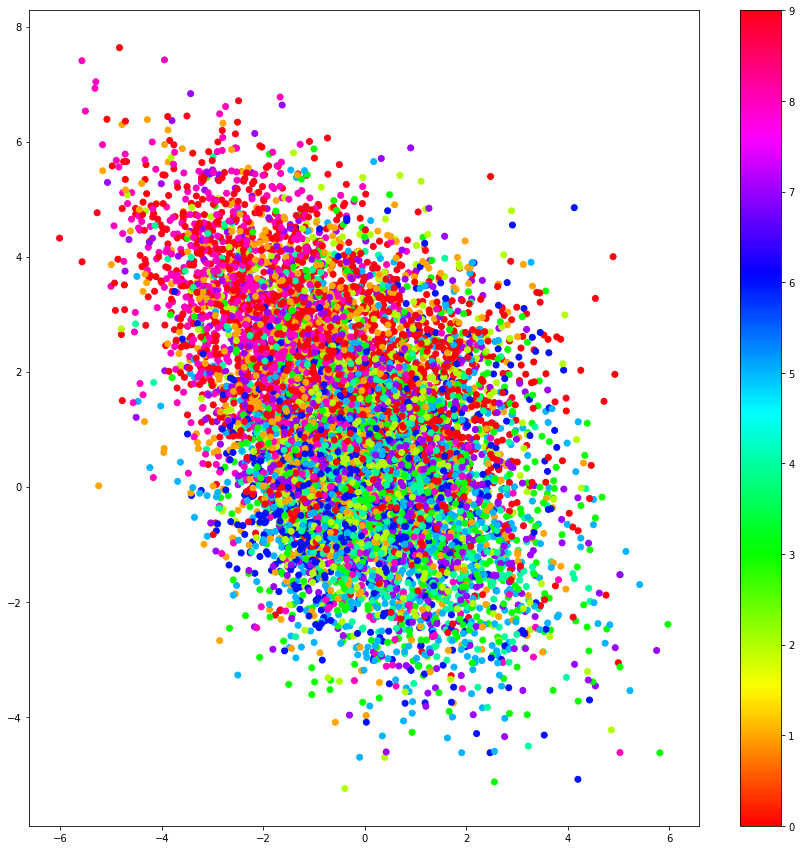

In [114]:
plot_distribution(encoder_cifar,X_test,Y_test)

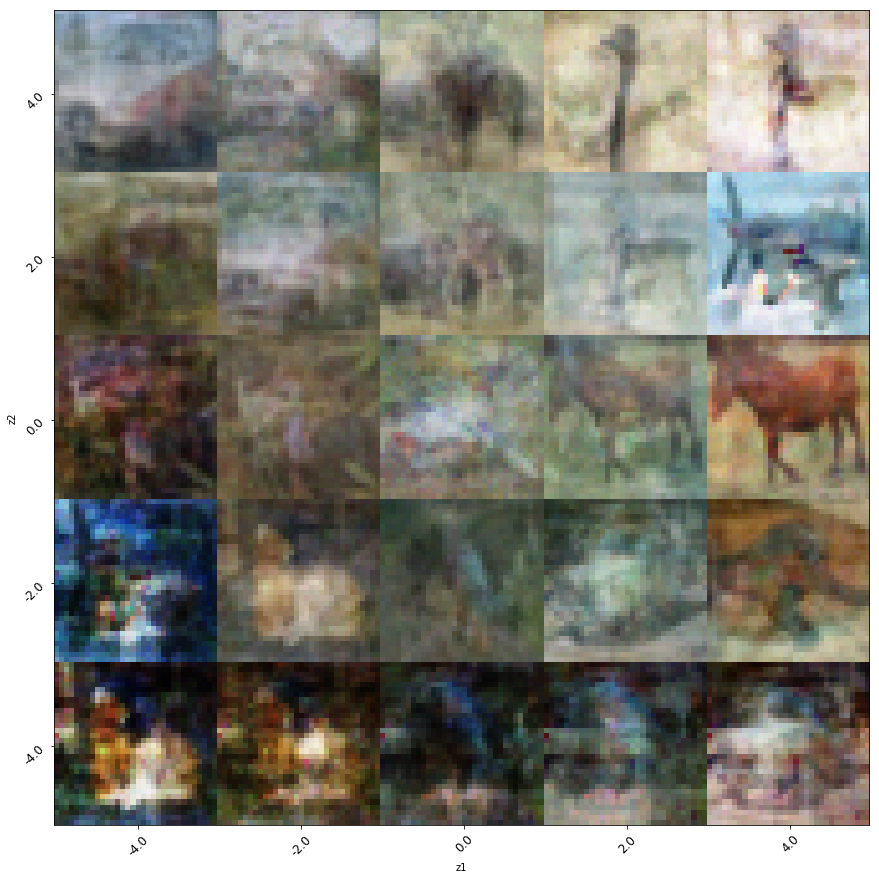

In [123]:
plot_model(decoder_cifar,n=5,dim=32,reshaper=lambda x:np.reshape(x,(-1,32,32,3)),channels=3)

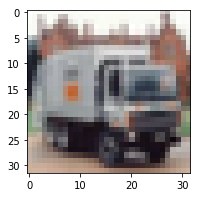

In [24]:
plt.rcParams['figure.figsize']=(3,3)
plt.imshow(np.reshape(X_test[11],(32,32,3)))
# print(np.reshape(X_test[9],(32,32,3)))